In [1]:
import pandas as pd
import numpy as np
import keras
import crested
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42  
matplotlib.rcParams["ps.fonttype"] = 42  
from pathlib import Path
import anndata
import h5py

2025-03-12 17:14:02.890701: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 17:14:02.929842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-12 17:14:05.398098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import pandas as pd

column_names = ["chrom", "start", "end", "name", "score", "strand"]

# Read the unibind bed files
bed_file_path = "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/gata3.bed"
chip_df = pd.read_csv(bed_file_path, sep="\t", header=None, names=column_names)

chip_df

,chrom,start,end,name,score,strand
0,chr1,778552,778560,GATA3_TGGTAAGA,90.0,-
1,chr1,912926,912934,GATA3_TGAAAAGT,85.1,+
2,chr1,960644,960652,GATA3_CGTTAAGC,91.3,+
3,chr1,996148,996156,GATA3_AGATAAAA,98.0,+
4,chr1,1005110,1005118,GATA3_TGATAAGG,98.5,-
...,...,...,...,...,...,...
39692,chrY,21034141,21034149,GATA3_AGAAAACC,88.7,+
39693,chrY,21138525,21138533,GATA3_AGATAAGG,99.3,+
39694,chrY,21170057,21170065,GATA3_AGATAAGA,100.0,+
39695,chrY,56734848,56734856,GATA3_CGATTGGA,85.0,+


In [3]:
# Load peaks

peak_bed = "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/Merged__consensus_peaks.bed"
peak_bed="/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/sam/consensus_regions.bed"
peak_df = pd.read_csv(peak_bed, sep="\t", header=None, names=column_names)
peak_df

,chrom,start,end,name,score,strand
0,chr1,817094,817594,CD16_monocyte_peak_4,197,.
1,chr1,818575,819075,CytotoxicTcell_peak_9,0,.
2,chr1,819821,820321,CytotoxicTcell_peak_10,2,.
3,chr1,820583,821083,CD14_monocyte_peak_14a,1,.
4,chr1,821323,821823,CD14_monocyte_peak_14b,4,.
...,...,...,...,...,...,...
327959,chrY,21260264,21260764,CD4_Tcell_peak_104744,11,.
327960,chrY,21300185,21300685,Dendriticcell_peak_89630,11,.
327961,chrY,21302627,21303127,Dendriticcell_peak_89631,11,.
327962,chrY,21422119,21422619,Dendriticcell_peak_89632,17,.


Keep only the hits overlapping with peak set

In [4]:
import pandas as pd

# Merge the two DataFrames on overlapping intervals
merged_df = pd.merge(
    chip_df,
    peak_df,
    on="chrom",
    suffixes=("_chip", "_peak")
)

# Filter for overlaps
subset_chip_df = merged_df[
    (merged_df["start_chip"] >= merged_df["start_peak"]) &
    (merged_df["end_chip"] <= merged_df["end_peak"])
]

subset_chip_df

,chrom,start_chip,end_chip,name_chip,score_chip,strand_chip,start_peak,end_peak,name_peak,score_peak,strand_peak
31028,chr1,912926,912934,GATA3_TGAAAAGT,85.1,+,912618,913118,Dendriticcell_peak_12,11,.
62052,chr1,960644,960652,GATA3_CGTTAAGC,91.3,+,960327,960827,Dendriticcell_peak_19,81,.
93072,chr1,996148,996156,GATA3_AGATAAAA,98.0,+,995805,996305,Bcell_peak_36,7,.
124080,chr1,1005110,1005118,GATA3_TGATAAGG,98.5,-,1004938,1005438,CD16_monocyte_peak_34,14,.
155155,chr1,1116178,1116186,GATA3_AGAAAACT,85.7,+,1115984,1116484,CD14_monocyte_peak_71,425,.
...,...,...,...,...,...,...,...,...,...,...,...
678021810,chrY,20575692,20575700,GATA3_TGATTACG,91.1,-,20575467,20575967,CD16_monocyte_peak_112609,195,.
678022005,chrY,20735533,20735541,GATA3_AGATAAGA,100.0,-,20735142,20735642,Bcell_peak_100257,3,.
678022196,chrY,20747159,20747167,GATA3_AGAGAAGC,85.7,+,20746971,20747471,CD4_Tcell_peak_104730,1,.
678022577,chrY,20785063,20785071,GATA3_TGATATAG,87.4,+,20784929,20785429,CD4_Tcell_peak_104732,1,.


In [5]:
sorted_chip_df = subset_chip_df.sort_values(by="score_chip", ascending=False)
sorted_chip_df

,chrom,start_chip,end_chip,name_chip,score_chip,strand_chip,start_peak,end_peak,name_peak,score_peak,strand_peak
307394633,chr19,18507311,18507319,GATA3_AGATAAGA,100.0,+,18507068,18507568,CD16_monocyte_peak_52205,70,.
677743462,chrX,150570729,150570737,GATA3_AGATAAGA,100.0,-,150570483,150570983,Naturalkillercell_peak_85021,8,.
306560949,chr19,16369263,16369271,GATA3_AGATAAGA,100.0,+,16368932,16369432,CD16_monocyte_peak_51838,294,.
676836756,chrX,124725632,124725640,GATA3_AGATAAGA,100.0,-,124725384,124725884,CD4_Tcell_peak_104063,1,.
677220142,chrX,135384399,135384407,GATA3_AGATAAGA,100.0,+,135384131,135384631,Naturalkillercell_peak_84897,67,.
...,...,...,...,...,...,...,...,...,...,...,...
610768234,chr7,80217450,80217458,GATA3_TGATGACA,85.0,-,80217168,80217668,CD4_Tcell_peak_91045,0,.
513985526,chr5,16617874,16617882,GATA3_AGATTGGA,85.0,+,16617599,16618099,CytotoxicTcell_peak_59704d,97,.
134756094,chr10,70162877,70162885,GATA3_TGATGACA,85.0,-,70162778,70163278,Dendriticcell_peak_10559,96,.
352253217,chr2,101251999,101252007,GATA3_AGATATTA,85.0,-,101251893,101252393,CD4_Tcell_peak_54901a,39,.


# Load DeepPBMC

In [2]:
bigwigs_folder = "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/bw/"
regions_file = (
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/extended_peaks.bed"
)
chromsizes_file = "/home/VIB.LOCAL/niklas.kempynck/nkemp/human/genome/hg38.chrom.sizes"

In [3]:
import crested
genome_dir = Path("/home/VIB.LOCAL/niklas.kempynck/nkemp/human/genome/")
genome = crested.Genome(genome_dir / "hg38.fa", genome_dir / "hg38.chrom.sizes")
crested.register_genome(genome)

2025-03-12T17:14:16.022138+0100 INFO Genome hg38 registered.


In [4]:
import anndata

adata = anndata.read_h5ad("/home/VIB.LOCAL/niklas.kempynck/nkemp/software/crested_notebooks/crested_out/pbmc.h5ad")

datamodule = crested.tl.data.AnnDataModule(
    adata,
    batch_size=256,  # lower this if you encounter OOM errors
)
adata.layers=[]
adata.layers

Layers with keys: 

In [5]:
import keras

model_path ='/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/sam/finetune_filtered-regions.keras'
model = keras.models.load_model(
    model_path, compile=False
) 

2025-03-12 17:14:17.342150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78790 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:d2:00.0, compute capability: 9.0


## Set of Unibind regions

In [22]:
top_n=len(sorted_chip_df)#100#26983

sequences=[]
for i in range(top_n):
    row= sorted_chip_df.iloc[i]
    
    chrom= row['chrom']
    start=int(row['start_peak']-807)
    end=int(row['end_peak']+807)
    sequence = genome.fetch(chrom, start, end).upper()
    sequences.append(sequence)

In [49]:
scores, one_hot_encoded_sequences = evaluators[2].calculate_contribution_scores_sequence(sequences, ['Bcell'], method='expected_integrated_grad', disable_tqdm=False)

2025-02-10T13:20:59.155484+0100 INFO Calculating contribution scores for 1 class(es) and 15748 region(s).


Region: 100%|██████████| 15748/15748 [5:19:12<00:00,  1.22s/it]  


In [50]:
scores.shape

(15748, 1, 2114, 4)

In [27]:
scores = np.squeeze(scores, axis=1)

Best to save your file

In [51]:
np.savez("/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/Sam_CD4_Tcell_contrib.npz",np.transpose(scores,(0,2,1)))

ValueError: axes don't match array

In [ ]:
np.savez("/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/Sam_CD4_Tcell_oh.npz", np.transpose(one_hot_encoded_sequences,(0,2,1)))

In [30]:
scores = np.load("/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/Sam_Bcell_contrib.npz")['arr_0']
scores = np.transpose(scores, (0,2,1))
one_hot_encoded_sequences = np.load("/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/Sam_Bcell_oh.npz")['arr_0']
one_hot_encoded_sequences = np.transpose(one_hot_encoded_sequences, (0,2,1))


Here we get the seqlets from the contribution scores of the top_n regions, and see if they overlap with a unibind hit

In [33]:
from tqdm import tqdm

seqlet_starts=[]
seqlet_ends = []
p_values=[]
attributions=[]
attributions_exact=[]


for i in tqdm(range(top_n)):
    oh_seq = one_hot_encode_sequence(sequences[i])[0].T#one_hot_encoded_sequences[i].T
    X_attr = scores[i].T
    X_attr=X_attr*oh_seq
    X_attr = np.expand_dims(np.sum(X_attr, axis=0),axis=0)
    
    seqlets = recursive_seqlets(X_attr, threshold=0.05)
    
    row=sorted_chip_df.iloc[i]
    
    chrom= row['chrom']
    start=int(row['start_peak']-807)
    end=int(row['end_peak']+807)
    
    tf_start=int(row['start_chip']-start)
    tf_end = int(row['end_chip']-start)

    attribution = (np.mean(X_attr[0,tf_start:tf_end]))

    overlap_rows = get_row_with_overlap(seqlets, tf_start, tf_end)
    if len(overlap_rows)>0:
        r = overlap_rows.iloc[0]
        seqlet_starts.append(start+int(r['start']))
        seqlet_ends.append(start+int(r['end']))
        p_values.append(r['p-value'])
        attributions.append(r['attribution'])
        attributions_exact.append(attribution)

    else:
        seqlet_starts.append(np.nan)
        seqlet_ends.append(np.nan)
        p_values.append(np.nan)
        attributions.append(np.nan)
        attributions_exact.append(attribution)
    

100%|██████████| 7707/7707 [00:20<00:00, 375.07it/s]


In [34]:
df_final = sorted_chip_df.head(top_n).copy()
df_final.loc[:,'seqlet_start'] = seqlet_starts
df_final.loc[:,'seqlet_end'] = seqlet_ends
df_final.loc[:,'seqlet_p_val']= p_values
df_final.loc[:,'seqlet_attribution'] = attributions
df_final.loc[:,'chip_attribution'] = attributions_exact

In [35]:
df_final.head(20)

,chrom,start_chip,end_chip,name_chip,score_chip,strand_chip,start_peak,end_peak,name_peak,score_peak,strand_peak,seqlet_start,seqlet_end,seqlet_p_val,seqlet_attribution,chip_attribution
97248277,chr14,88130030,88130045,EBF1_AGTCCCCAGGGACTT,100.0,-,88129877,88130377,CytotoxicTcell_peak_23411,70,.,88130032.0,88130045.0,0.003356,0.049504,0.003529
109722676,chr16,56889014,56889029,EBF1_AGTCCCCAGGGAGTT,99.8,-,56888743,56889243,Bcell_peak_35136,71,.,56889018.0,56889030.0,0.013417,1.334044,0.093408
95261805,chr14,65321045,65321060,EBF1_ATTCCCCAGGGACTT,99.7,-,65320924,65321424,Bcell_peak_27559,3,.,65321045.0,65321059.0,0.010671,0.038391,0.002656
251495808,chr7,597950,597965,EBF1_AGTCCCCTGGGAGTT,99.5,-,597597,598097,CD14_monocyte_peak_126426,1,.,597953.0,597964.0,0.004307,0.033426,0.002268
180626659,chr22,39384989,39385004,EBF1_AGTCCCCTGGGAATT,99.4,-,39384728,39385228,Bcell_peak_62444,1,.,39384993.0,39385004.0,0.009138,0.013968,0.000947
175748318,chr20,41177666,41177681,EBF1_AGTCCCCTGGGAATT,99.4,-,41177625,41178125,CD4_Tcell_peak_61364,1,.,41177672.0,41177696.0,0.006024,0.014853,0.000754
222139050,chr5,112684341,112684356,EBF1_ATTCCCTAGGGAGTT,99.2,+,112684094,112684594,Bcell_peak_75609,1,.,112684340.0,112684347.0,0.030612,-0.009622,-0.000778
89467640,chr13,30371819,30371834,EBF1_AGTCCCCAGGGACCT,99.2,+,30371565,30372065,Dendriticcell_peak_22589,431,.,30371827.0,30371833.0,0.014790,0.239284,0.027019
253857273,chr7,27923093,27923108,EBF1_AGTCCCCAGGGAGCT,99.0,-,27922866,27923366,Bcell_peak_85520,2,.,27923089.0,27923107.0,0.007293,0.179951,0.008655
277786600,chr9,72025008,72025023,EBF1_AGTCCCCAGGGAGAT,99.0,-,72024904,72025404,CD16_monocyte_peak_106293,38,.,72025011.0,72025022.0,0.003549,0.207100,0.013473


In [36]:
# Determine true positives (non-NaN in seqlet_start)
true_positives = df_final['seqlet_start'].notna().sum()

# Determine false negatives (NaN in seqlet_start)
false_negatives = df_final['seqlet_start'].isna().sum()

# Calculate recall
recall = true_positives / (true_positives + false_negatives)

# Output the results
print(f"True Positives (TP): {true_positives}")
print(f"False Negatives (FN): {false_negatives}")
print(f"Recall: {recall:.2f}")

True Positives (TP): 6300
False Negatives (FN): 1407
Recall: 0.82


### For all

In [ ]:
from tqdm import tqdm
ct_list= ['Bcell',
          'Bcell',
          'CD4_Tcell',
          'CD4_Tcell',
          'CD4_Tcell',
          'CD14_monocyte',
          'CD14_monocyte'
         ]

chip_bed_files = [
    '/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pax5/pax5.bed',
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/ebf1_unibind.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/runx1.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/gata3.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ets1/ets1_unibind.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/cebpa/cebpa.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/spi1_2/spi1.bed",
]

unibind_dfs = []

for chip_bed_file in tqdm(chip_bed_files):
    print(chip_bed_file)
    column_names = ["chrom", "start", "end", "name", "score", "strand"]

    # Read the unibind bed files
    chip_df = pd.read_csv(chip_bed_file, sep="\t", header=None, names=column_names)
    
    # Merge the two DataFrames on overlapping intervals
    merged_df = pd.merge(
        chip_df,
        peak_df,
        on="chrom",
        suffixes=("_chip", "_peak")
    )
    
    # Filter for overlaps
    subset_chip_df = merged_df[
        (merged_df["start_chip"] >= merged_df["start_peak"]) &
        (merged_df["end_chip"] <= merged_df["end_peak"])
    ]
    
    sorted_chip_df = subset_chip_df.sort_values(by="score_chip", ascending=False)
    unibind_dfs.append(sorted_chip_df)


In [ ]:
#out_dirs = [
#    '/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pax5/',
#    #"/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/",
#    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/",
#    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/",
#    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ets1/",
#    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/cebpa/",
#    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/spi1_2/",
#]
#for a, sorted_chip_df in enumerate(unibind_dfs):
#    top_n=len(sorted_chip_df)#100#26983
#    
#    sequences=[]
#    for i in range(top_n):
#        row= sorted_chip_df.iloc[i]
#        
#        chrom= row['chrom']
#        start=int(row['start_peak']-807)
#        end=int(row['end_peak']+807)
#        sequence = genome.fetch(chrom, start, end).upper()
#        sequences.append(sequence)
#    scores, one_hot_encoded_sequences = evaluators[2].calculate_contribution_scores_sequence(sequences, ct_list[a], method='expected_integrated_grad', disable_tqdm=False)
#    scores = np.squeeze(scores, axis=1)
#    scores = np.transpose(scores,(0,2,1))
#    print(scores.shape)
#    one_hot_encoded_sequences = np.transpose(one_hot_encoded_sequences,(0,2,1))
#    np.savez(out_dirs[a]+"/Sam_"+ct_list[a]+"_contrib.npz",scores)
#    np.savez(out_dirs[a]+"/Sam_"+ct_list[a]+"_oh.npz", one_hot_encoded_sequences)
    

2025-02-11T10:04:05.155069+0100 INFO Calculating contribution scores for 1 class(es) and 26983 region(s).


Region:  14%|█▍        | 3817/26983 [1:19:27<7:55:38,  1.23s/it]

In [109]:
out_dirs = [
    '/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pax5/',
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ets1/",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/cebpa/",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/spi1_2/",
]
ct_list= ['Bcell',
          'Bcell',
          'CD4_Tcell',
          'CD4_Tcell',
          'CD4_Tcell',
          'CD14_monocyte',
          'CD14_monocyte'
         ]

recalls={}
tfs=['PAX5','EBF1','RUNX1','GATA3','ETS1','CEBPA','SPI']
a=0
for ct, outdir, sorted_chip_df, tf in zip(ct_list, out_dirs, unibind_dfs, tfs):
    scores = np.load(outdir+"Sam_"+ct+"_contrib.npz")['arr_0']
    scores = np.transpose(scores, (0,2,1))
    one_hot_encoded_sequences = np.load(outdir+"Sam_"+ct+"_oh.npz")['arr_0']
    one_hot_encoded_sequences = np.transpose(one_hot_encoded_sequences, (0,2,1))

    print(scores.shape)
    print(sorted_chip_df.shape)
    from tqdm import tqdm
    
    seqlet_starts=[]
    seqlet_ends = []
    p_values=[]
    attributions=[]
    attributions_exact=[]
    overlaps=[]
    
    
    for i in tqdm(range(len(sorted_chip_df))):
        oh_seq = one_hot_encode_sequence(sequences[i])[0].T#one_hot_encoded_sequences[i].T
        X_attr = scores[i].T
        X_attr=X_attr*oh_seq
        X_attr = np.expand_dims(np.sum(X_attr, axis=0),axis=0)
        
        seqlets = recursive_seqlets(X_attr, threshold=0.05)
        
        row=sorted_chip_df.iloc[i]
        
        chrom= row['chrom']
        start=int(row['start_peak']-807)
        end=int(row['end_peak']+807)
        
        tf_start=int(row['start_chip']-start)
        tf_end = int(row['end_chip']-start)
    
        attribution = (np.mean(X_attr[0,tf_start:tf_end]))
    
        overlap_rows = get_row_with_overlap(seqlets, tf_start, tf_end)
        if len(overlap_rows)>0:
            r = overlap_rows.iloc[0]
            seqlet_starts.append(start+int(r['start']))
            seqlet_ends.append(start+int(r['end']))
            p_values.append(r['p-value'])
            attributions.append(r['attribution'])
            overlaps.append(r['overlap'])
            attributions_exact.append(attribution)
    
        else:
            seqlet_starts.append(np.nan)
            seqlet_ends.append(np.nan)
            p_values.append(np.nan)
            attributions.append(np.nan)
            overlaps.append(np.nan)
            attributions_exact.append(attribution)

    df_final = sorted_chip_df.head(top_n).copy()
    df_final.loc[:,'seqlet_start'] = seqlet_starts
    df_final.loc[:,'seqlet_end'] = seqlet_ends
    df_final.loc[:,'seqlet_p_val']= p_values
    df_final.loc[:,'seqlet_attribution'] = attributions
    df_final.loc[:,'chip_attribution'] = attributions_exact
    df_final.loc[:,'UniBind-Seqlet overlap fraction'] = overlaps


    true_positives = df_final['seqlet_start'].notna().sum()
    
    # Determine false negatives (NaN in seqlet_start)
    false_negatives = df_final['seqlet_start'].isna().sum()
    
    # Calculate recall
    recall = true_positives / (true_positives + false_negatives)
    
    # Output the results
    print(f"True Positives (TP): {true_positives}")
    print(f"False Negatives (FN): {false_negatives}")
    print(f"Recall: {recall:.2f}")
    recalls[tf]={}
    recalls[tf]['recall']=recall
    recalls[tf]['total']=true_positives+false_negatives
    unibind_dfs[a]=df_final
    a+=1

(26983, 2114, 4)
(26983, 16)


100%|██████████| 26983/26983 [01:13<00:00, 367.42it/s]


True Positives (TP): 13156
False Negatives (FN): 13827
Recall: 0.49
(7707, 2114, 4)
(7707, 16)


100%|██████████| 7707/7707 [00:21<00:00, 358.78it/s]


True Positives (TP): 5916
False Negatives (FN): 1791
Recall: 0.77
(15748, 2114, 4)
(15748, 16)


100%|██████████| 15748/15748 [00:44<00:00, 353.32it/s]


True Positives (TP): 11650
False Negatives (FN): 4098
Recall: 0.74
(20992, 2114, 4)
(20992, 16)


100%|██████████| 20992/20992 [00:58<00:00, 359.76it/s]


True Positives (TP): 7122
False Negatives (FN): 13870
Recall: 0.34
(7397, 2114, 4)
(7397, 16)


100%|██████████| 7397/7397 [00:21<00:00, 349.49it/s]


True Positives (TP): 6761
False Negatives (FN): 636
Recall: 0.91
(27152, 2114, 4)
(27152, 16)


100%|██████████| 27152/27152 [01:19<00:00, 341.93it/s]


True Positives (TP): 25267
False Negatives (FN): 1885
Recall: 0.93
(29620, 2114, 4)
(29620, 16)


100%|██████████| 29620/29620 [01:29<00:00, 332.44it/s]

True Positives (TP): 29199
False Negatives (FN): 421
Recall: 0.99


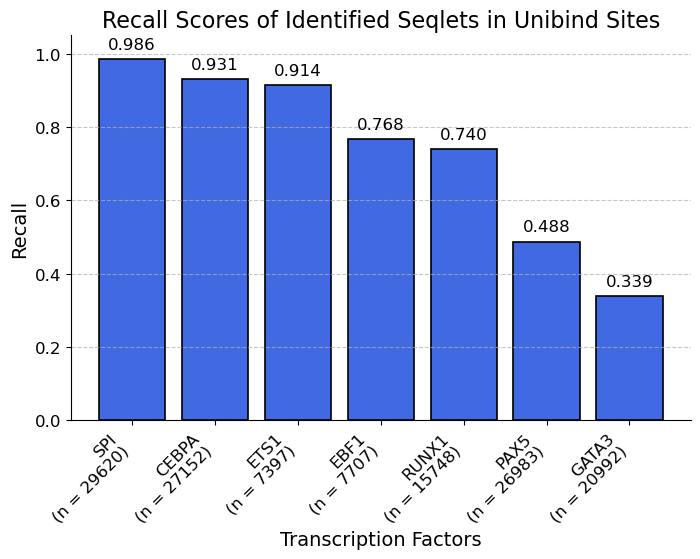

In [110]:
# Sorting by recall values
sorted_factors = sorted(recalls, key=lambda x: recalls[x]['recall'], reverse=True)
sorted_recalls = [recalls[factor]['recall'] for factor in sorted_factors]
sorted_totals = [recalls[factor]['total'] for factor in sorted_factors]

# Generate new x-axis labels with (n = total)
x_labels = [f"{factor}\n(n = {total})" for factor, total in zip(sorted_factors, sorted_totals)]

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x_labels, sorted_recalls, color='royalblue', edgecolor='black', linewidth=1.2)

# Aesthetics
ax.set_ylabel('Recall', fontsize=14)
ax.set_xlabel('Transcription Factors', fontsize=14)
ax.set_title('Recall Scores of Identified Seqlets in Unibind Sites', fontsize=16)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', 
            ha='center', va='bottom', fontsize=12, color='black')

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.xticks(rotation=45, fontsize=12, ha='right', va='top')
plt.yticks(fontsize=12)
plt.savefig('paperfigs/unibind_recall_ALL.pdf', bbox_inches='tight')
plt.show()

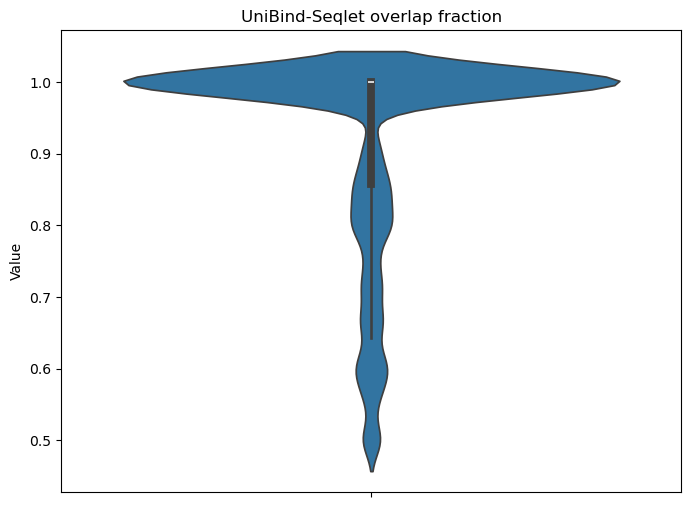

count    13156.000000
mean         0.918775
std          0.142515
min          0.500000
25%          0.857143
50%          1.000000
75%          1.000000
max          1.000000
Name: UniBind-Seqlet overlap fraction, dtype: float64

In [120]:
import seaborn as sns
df = unibind_dfs[-7]

# Descriptive statistics
description = df['UniBind-Seqlet overlap fraction'].describe()

# Violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(y=df['UniBind-Seqlet overlap fraction'])
plt.title('UniBind-Seqlet overlap fraction')
plt.ylabel('Value')
plt.show()
description

# Analysis on modisco top regions

First we define all relevant files, patterns and directories and add them to the tf_dict dictionary.

In [6]:
tf_dict = {}
tf_list = ['PAX5','EBF1','POU2F2', 'RUNX1', 'GATA3', 'ETS1', 'CEBPA', 'SPI1']
ct_list= ['Bcell','Bcell','Bcell','CD4_Tcell','CD4_Tcell','CD4_Tcell', 'CD14_monocyte', 'CD14_monocyte']

chip_bed_files = [
    '/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pax5/pax5_CHIP.bed',
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/ebf1_CHIP.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pou2f2/pou2f2_chip.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/runx1_CHIP.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/gata3_CHIP.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ets1/ets1_CHIP.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/cebpa/cebpa_CHIP.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/spi1_2/spi1_CHIP.bed",
]
unibind_bed_files = [
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pax5/pax5.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/ebf1_unibind.bed",
    None,
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/runx1.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/gata3.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ets1/ets1_unibind.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/cebpa/cebpa.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/spi1_2/spi1.bed",
]
chip_bw_files = [
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pax5/PAX5.bigWig",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/EBF1.bigWig",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pou2f2/pou2f2.bigWig",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/runx1.bw",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/gata3.bw",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ets1/ets1.bw",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/cebpa/cebpa.bw",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/spi1_2/spi1.bw",
]
pattern_nrs = [[3,7,8,13], [2], [0,4], [0,5,6,8], [3], [1,7], [0,2], [0]]

pattern_nrs = [[5, 6, 9, 12, 13, 19, 23], 
               [3,24],
               [2],
               [2, 4, 19, 22, 25], 
               [7], #[3,7,27]
               [0], 
               [0, 4], 
               [2]]

for i, tf in enumerate(tf_list):
    tf_dict[tf]={}
    tf_dict[tf]['cell_type']=ct_list[i]
    tf_dict[tf]['chip_bed']=chip_bed_files[i]
    tf_dict[tf]['chip_bw']=chip_bw_files[i]
    tf_dict[tf]['unibind_bed']=unibind_bed_files[i]
    tf_dict[tf]['pattern_indices']=pattern_nrs[i]


top_n = 1000
contribution_dir="/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/sam/modisco/"
modisco_regions="/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/sam/modisco_regions.csv"


## Load the patterns from the modisco files

In [7]:
def recursively_load_h5_data(h5_group):
    """
    Recursively load all data from an HDF5 group or dataset into Python objects.
    """
    if isinstance(h5_group, h5py.Group):
        # If it's a group, recurse into its items
        return {key: recursively_load_h5_data(h5_group[key]) for key in h5_group.keys()}
    elif isinstance(h5_group, h5py.Dataset):
        # If it's a dataset, load its value into memory
        return h5_group[()]
    else:
        # Unknown type, return as-is
        return h5_group

for tf in tf_dict:
    ppms = []
    patterns = []
    h5_file = contribution_dir+'/'+tf_dict[tf]['cell_type']+'_modisco_results.h5'
    with h5py.File(h5_file) as hdf5_results:
        for metacluster_name in ['pos_patterns']:
            pattern_idx = 0
            for i in range(len(list(hdf5_results[metacluster_name]))):
                p = "pattern_" + str(i)
                pattern = hdf5_results[metacluster_name][p]
                pattern_data = recursively_load_h5_data(pattern)
                patterns.append(pattern_data)
    tf_dict[tf]['patterns']=patterns

## Load the regions used for modisco

In [8]:
for tf in tf_dict:
    file_path = modisco_regions
    region_df = pd.read_csv(file_path)
    region_df['Class name'] = region_df['Class name'].str.lstrip('Merged__')
    region_df['Class name'] = region_df['Class name'].replace('B_cell','Bcell')
    region_df['Class name'] = region_df['Class name'].replace('CD4_T_cell','CD4_Tcell')

    region_df = region_df.loc[region_df['Class name']==tf_dict[tf]['cell_type']]
    region_df = region_df.head(top_n)
    region_df
    tf_dict[tf]['region_df']=region_df

In [9]:
tf_dict['EBF1']['region_df']

,region,chr,start,end,split,Class name,rank,proportion_score
0,chrY:7452461-7454575,chrY,7452461,7454575,train,Bcell,1,0.982793
1,chr7:846223-848337,chr7,846223,848337,train,Bcell,2,0.972670
2,chrX:104696353-104698467,chrX,104696353,104698467,train,Bcell,3,0.971218
3,chr3:16432755-16434869,chr3,16432755,16434869,train,Bcell,4,0.965997
4,chr15:69978952-69981066,chr15,69978952,69981066,train,Bcell,5,0.963811
...,...,...,...,...,...,...,...,...
995,chr8:109595011-109597125,chr8,109595011,109597125,val,Bcell,996,0.766843
996,chr7:27585977-27588091,chr7,27585977,27588091,train,Bcell,997,0.766802
997,chr17:31537218-31539332,chr17,31537218,31539332,train,Bcell,998,0.766793
998,chr8:30649094-30651208,chr8,30649094,30651208,val,Bcell,999,0.766790


## Load the ChIP Bed files

In [10]:
# Define the base column names for a standard BED file
base_column_names = ["chrom", "start", "end", "name", "score", "strand", "signal_value", "p-val", "-log10(q-value)", "peak-summit"]
chip_df_list=[]
for tf in tf_dict:
    bed_file_path = tf_dict[tf]['chip_bed']
    
    bed_preview = pd.read_csv(bed_file_path, sep="\t", header=None, nrows=1)
    
    # Extend the column names list to match the number of columns in the file
    extra_columns = [f"extra_col_{i}" for i in range(len(bed_preview.columns) - len(base_column_names))]
    column_names = base_column_names + extra_columns
    
    # Read the BED file into a DataFrame with the dynamically generated column names
    chip_all_df = pd.read_csv(bed_file_path, sep="\t", header=None, names=column_names)
    
    chip_df_list.append(chip_all_df)

## Load the UniBind Bed files

In [11]:
import pandas as pd

# Define the base column names for a standard BED file
base_column_names = ["chrom", "start", "end", "name", "score", "strand", "signal_value", "p-val", "-log10(q-value)", "peak-summit"]

unibind_df_list=[]
for tf in tf_dict:
    # Read the BED file to determine the number of columns
    bed_file_path = tf_dict[tf]['unibind_bed']
    if bed_file_path:
        bed_preview = pd.read_csv(bed_file_path, sep="\t", header=None, nrows=1)
        
        # Extend the column names list to match the number of columns in the file
        extra_columns = [f"extra_col_{i}" for i in range(len(bed_preview.columns) - len(base_column_names))]
        column_names = base_column_names + extra_columns
        
        # Read the BED file into a DataFrame with the dynamically generated column names
        unibind_df = pd.read_csv(bed_file_path, sep="\t", header=None, names=column_names)
        
        unibind_df_list.append(unibind_df)
    else:
        unibind_df_list.append(None)

## Calculate overlapping Unibind hits in the top regions used in modisco

In [12]:
for i,tf in enumerate(tf_dict):
    possible_hits = []
    regions_to_process = tf_dict[tf]['region_df'].head(top_n) if top_n else tf_dict[tf]['region_df']
    unibind_df = unibind_df_list[i]
    if unibind_df is not None:
        for _, region in regions_to_process.iterrows():
            overlaps = unibind_df[
                (unibind_df["chrom"] == region["chr"]) &
                (unibind_df["start"] < region["end"] - 557) &
                (unibind_df["end"] > region["start"] + 557)
            ]
            for _, overlap in overlaps.iterrows():
                possible_hits.append({
                    "region": region['region'],
                    "region_chr": region["chr"],
                    "region_start": region["start"],
                    "region_end": region["end"],
                    "chip_chr": overlap["chrom"],
                    "chip_start": int(overlap["start"]),
                    "chip_end": int(overlap["end"]),
                    "chip_name": overlap["name"],
                    "chip_score": overlap["score"],
                    "chip_strand": overlap["strand"],
                    "status": "Possible Hit"
                })
        
        possible_hits_df_unibind = pd.DataFrame(possible_hits)
        tf_dict[tf]['unibind_hits_df'] = possible_hits_df_unibind
    else:
        tf_dict[tf]['unibind_hits_df'] = None

In [13]:
tf_dict['RUNX1']['unibind_hits_df']

,region,region_chr,region_start,region_end,chip_chr,chip_start,chip_end,chip_name,chip_score,chip_strand,status
0,chrX:43105205-43107319,chrX,43105205,43107319,chrX,43106178,43106189,RUNX1_AGTGGTGGTTT,89.2,-,Possible Hit
1,chr2:170650850-170652964,chr2,170650850,170652964,chr2,170651916,170651927,RUNX1_TGATGTGGTTT,98.2,+,Possible Hit
2,chr2:19558727-19560841,chr2,19558727,19560841,chr2,19559656,19559667,RUNX1_TTTTTTGGTTT,91.1,-,Possible Hit
3,chrX:46319573-46321687,chrX,46319573,46321687,chrX,46320746,46320757,RUNX1_CTTTGTGGGTA,91.3,-,Possible Hit
4,chr5:57450695-57452809,chr5,57450695,57452809,chr5,57451441,57451452,RUNX1_TTTTGTTGTTT,90.6,+,Possible Hit
...,...,...,...,...,...,...,...,...,...,...,...
338,chr6:136752793-136754907,chr6,136752793,136754907,chr6,136753782,136753793,RUNX1_TCTTGTGGTAT,92.2,-,Possible Hit
339,chr22:45340586-45342700,chr22,45340586,45342700,chr22,45341591,45341602,RUNX1_TCATGTGGGTG,88.1,-,Possible Hit
340,chr17:73821521-73823635,chr17,73821521,73823635,chr17,73822533,73822544,RUNX1_ATCTGTGGCTG,88.7,-,Possible Hit
341,chr10:97780992-97783106,chr10,97780992,97783106,chr10,97782014,97782025,RUNX1_CGATGTGGCTT,92.0,+,Possible Hit


## Retrieve seqlet positions inside top modisco regions

In [14]:
for tf in tf_dict:
    seqlet_starts=[]
    seqlet_chroms=[]
    seqlet_ends=[]
    seqlet_regions=[]
    seqlet_attributions=[]

    pattern_nrs= tf_dict[tf]['pattern_indices']
    patterns = tf_dict[tf]['patterns']
    region_df = tf_dict[tf]['region_df']
    
    for pattern_nr in pattern_nrs:
        pattern = patterns[pattern_nr]
        for i in range(pattern['seqlets']['n_seqlets'][0]):
            region = pattern['seqlets']['example_idx'][i]
            if region<top_n:
                region_id = region_df.iloc[region]['region']
                region_chr = region_df.iloc[region]['chr']
                region_start = region_df.iloc[region]['start']
                region_end = region_df.iloc[region]['end']
            
                seqlet_start = region_start+pattern['seqlets']['start'][i]+557
                seqlet_end = seqlet_start+30
                seqlet_chrom = region_chr
    
                average_contrib=pattern['seqlets']['contrib_scores'][i]
                average_contrib = average_contrib[average_contrib!=0]
                average_contrib = np.mean(average_contrib)
            
                seqlet_starts.append(seqlet_start)
                seqlet_ends.append(seqlet_end)
                seqlet_chroms.append(seqlet_chrom)
                seqlet_regions.append(region_id)
                seqlet_attributions.append(average_contrib)
    
        
    seqlet_df= pd.DataFrame({
        'region': seqlet_regions,
        'chr':seqlet_chroms,
        'start':seqlet_starts,
        'end':seqlet_ends,
        'average_contrib':seqlet_attributions 
    })
    tf_dict[tf]['seqlet_df']=seqlet_df

In [15]:
tf='POU2F2'
tf_dict[tf]['seqlet_df']

,region,chr,start,end,average_contrib
0,chr3:16432755-16434869,chr3,16433734,16433764,0.065044
1,chr12:26155420-26157534,chr12,26156390,26156420,0.071910
2,chr1:204840873-204842987,chr1,204841964,204841994,0.033481
3,chr2:25416945-25419059,chr2,25418021,25418051,0.059777
4,chr4:75948184-75950298,chr4,75949222,75949252,0.044298
...,...,...,...,...,...
551,chr6:72381974-72384088,chr6,72383170,72383200,0.000791
552,chr15:94257369-94259483,chr15,94258611,94258641,0.001658
553,chr16:11285704-11287818,chr16,11286829,11286859,0.001742
554,chr6:1796329-1798443,chr6,1797289,1797319,0.001423


## Calculate precision and recall of Seqlets inside ChIP-seq peaks

In [16]:
def calculate_precision_recall(seqlet_df, chip_all_df, region_df, top_n=None):
    """
    Calculate precision and recall for overlap between seqlet_df and chip_all_df, with region_df for context.

    Parameters:
    - seqlet_df (pd.DataFrame): DataFrame with seqlets.
    - chip_all_df (pd.DataFrame): DataFrame with ChIP-seq data.
    - region_df (pd.DataFrame): DataFrame with regions for possible hits.
    - top_n (int, optional): Limit the number of regions processed from region_df.

    Returns:
    - results_df (pd.DataFrame): DataFrame with detailed overlap information.
    - precision (float): Precision value.
    - recall (float): Recall value.
    """
    # Initialize results and counts
    results = []
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Step 1: True Positives and False Positives
    for _, seqlet in seqlet_df.iterrows():
        overlaps = chip_all_df[
            (chip_all_df["chrom"] == seqlet["chr"]) &
            (chip_all_df["start"] < seqlet["end"] + 5) &
            (chip_all_df["end"] > seqlet["start"] - 5)
        ]
        if not overlaps.empty:
            for _, overlap in overlaps.iterrows():
                results.append({
                    "region": seqlet['region'],
                    "seqlet_chr": seqlet["chr"],
                    "seqlet_start": seqlet["start"],
                    "seqlet_end": seqlet["end"],
                    "seqlet_average_contrib": seqlet["average_contrib"],
                    "chip_chr": overlap["chrom"],
                    "chip_start": int(overlap["start"]),
                    "chip_end": int(overlap["end"]),
                    "chip_name": overlap["name"],
                    "chip_score": overlap["score"],
                    "chip_strand": overlap["strand"],
                    "status": "True Positive"
                })
            true_positives += 1
        else:
            results.append({
                "region": seqlet['region'],
                "seqlet_chr": seqlet["chr"],
                "seqlet_start": seqlet["start"],
                "seqlet_end": seqlet["end"],
                "seqlet_average_contrib": seqlet["average_contrib"],
                "chip_chr": np.nan,
                "chip_start": np.nan,
                "chip_end": np.nan,
                "chip_name": np.nan,
                "chip_score": np.nan,
                "chip_strand": np.nan,
                "status": "False Positive"
            })
            false_positives += 1

    # Step 2: Possible Hits (region_df vs chip_all_df)
    possible_hits = []
    regions_to_process = region_df.head(top_n) if top_n else region_df
    for _, region in regions_to_process.iterrows():
        overlaps = chip_all_df[
            (chip_all_df["chrom"] == region["chr"]) &
            (chip_all_df["start"] < region["end"] - 557) &
            (chip_all_df["end"] > region["start"] + 557)
        ]
        for _, overlap in overlaps.iterrows():
            possible_hits.append({
                "region": region['region'],
                "region_chr": region["chr"],
                "region_start": region["start"],
                "region_end": region["end"],
                "chip_chr": overlap["chrom"],
                "chip_start": int(overlap["start"]),
                "chip_end": int(overlap["end"]),
                "chip_name": overlap["name"],
                "chip_score": overlap["score"],
                "chip_strand": overlap["strand"],
                "status": "Possible Hit"
            })

    possible_hits_df = pd.DataFrame(possible_hits)

    # Step 3: False Negatives (possible hits not in seqlet_df)
    for _, hit in possible_hits_df.iterrows():
        matches = seqlet_df[
            (seqlet_df["chr"] == hit["chip_chr"]) &
            (seqlet_df["start"] < hit["chip_end"] + 5) &
            (seqlet_df["end"] > hit["chip_start"] - 5)
        ]
        if matches.empty:
            results.append({
                "region": hit['region'],
                "seqlet_chr": np.nan,
                "seqlet_start": np.nan,
                "seqlet_end": np.nan,
                "seqlet_average_contrib": np.nan,
                "chip_chr": hit["chip_chr"],
                "chip_start": hit["chip_start"],
                "chip_end": hit["chip_end"],
                "chip_name": hit["chip_name"],
                "chip_score": hit["chip_score"],
                "chip_strand": hit["chip_strand"],
                "status": "False Negative"
            })
            false_negatives += 1

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return results_df, precision, recall, true_positives, false_positives, false_negatives, possible_hits_df

In [17]:
# Assuming seqlet_df, chip_all_df, and region_df are defined
for i, tf in enumerate(tf_dict):
    print(tf)
    results_df, precision, recall, tp, fp, fn, possible_hits_df = calculate_precision_recall(tf_dict[tf]['seqlet_df'], chip_df_list[i], tf_dict[tf]['region_df'], top_n)
    tf_dict[tf]['results_df']=results_df
    tf_dict[tf]['chip_hits_df']=possible_hits_df
    # Display results
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")

PAX5
Precision: 0.393
Recall: 0.849
EBF1
Precision: 0.568
Recall: 0.601
POU2F2
Precision: 0.473
Recall: 0.619
RUNX1
Precision: 0.303
Recall: 0.859
GATA3
Precision: 0.596
Recall: 0.226
ETS1
Precision: 0.050
Recall: 0.855
CEBPA
Precision: 0.660
Recall: 0.946
SPI1
Precision: 0.320
Recall: 0.697


100%|██████████| 8/8 [01:16<00:00,  9.54s/it]


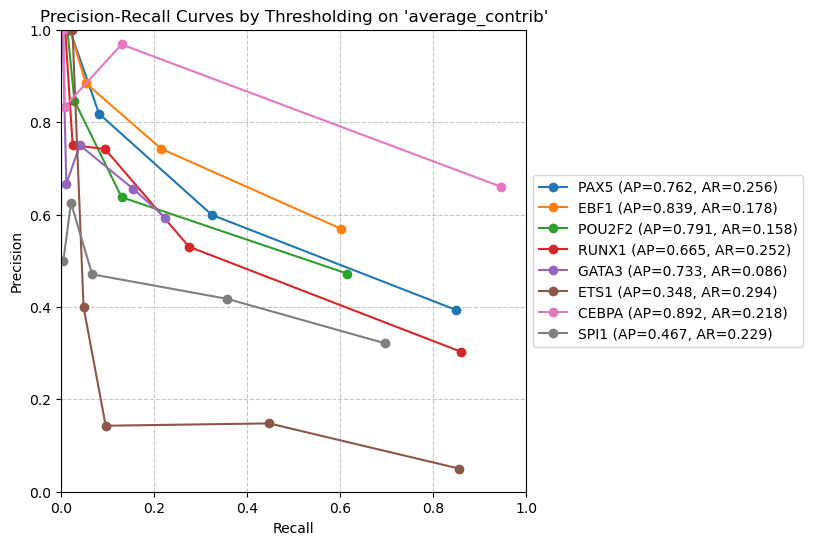

In [18]:
from tqdm import tqdm
def calculate_precision_recall_by_threshold(seqlet_df, chip_all_df, region_df, thresholds, top_n=None):
    """
    Calculate precision and recall for varying thresholds on 'average_contrib' in seqlet_df.

    Parameters:
    - seqlet_df (pd.DataFrame): DataFrame with seqlets.
    - chip_all_df (pd.DataFrame): DataFrame with ChIP-seq data.
    - region_df (pd.DataFrame): DataFrame with regions for possible hits.
    - thresholds (list or np.array): Thresholds for filtering seqlet_df by 'average_contrib'.
    - top_n (int, optional): Limit the number of regions processed from region_df.

    Returns:
    - precision_list (list): List of precision values for each threshold.
    - recall_list (list): List of recall values for each threshold.
    - thresholds (list): List of thresholds used.
    - avg_precision (float): Average precision across thresholds.
    - avg_recall (float): Average recall across thresholds.
    """
    precision_list = []
    recall_list = []

    for threshold in thresholds:
        # Filter seqlet_df by current threshold
        filtered_seqlet_df = seqlet_df.loc[seqlet_df['average_contrib'] > threshold].reset_index(drop=True)
        
        # Calculate precision and recall using the previous function
        _, precision, recall, _, _, _, _ = calculate_precision_recall(filtered_seqlet_df, chip_all_df, region_df, top_n)
        
        # Store results
        precision_list.append(precision)
        recall_list.append(recall)
    
    # Calculate average precision and recall
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    
    return precision_list, recall_list, thresholds, avg_precision, avg_recall

plt.figure(figsize=(6, 6))

for i, tf in tqdm(enumerate(tf_list), total=len(tf_dict)):
    # Define thresholds
    thresholds = np.linspace(np.min(tf_dict[tf]['seqlet_df']['average_contrib'].values), 
                             np.max(tf_dict[tf]['seqlet_df']['average_contrib'].values) * 0.95, 5)

    # Calculate precision, recall, and averages
    precision_list, recall_list, thresholds, avg_precision, avg_recall = calculate_precision_recall_by_threshold(
        tf_dict[tf]['seqlet_df'], chip_df_list[i], tf_dict[tf]['region_df'], thresholds
    )

    # Plot all PR curves on the same figure
    plt.plot(recall_list, precision_list, marker='o', label=f'{tf} (AP={avg_precision:.3f}, AR={avg_recall:.3f})')

# Formatting
plt.title("Precision-Recall Curves by Thresholding on 'average_contrib'")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.savefig('paperfigs/all_TFs_PR.pdf', bbox_inches='tight')
plt.show()


In [19]:
tf_dict[tf]['chip_hits_df'] # Dataframe for ChIP-seq peaks inside top modisco regions

,region,region_chr,region_start,region_end,chip_chr,chip_start,chip_end,chip_name,chip_score,chip_strand,status
0,chr2:239977541-239979655,chr2,239977541,239979655,chr2,239978476,239978837,SRX4001818.05_peak_53567,95,.,Possible Hit
1,chr1:25382325-25384439,chr1,25382325,25384439,chr1,25383179,25383499,SRX4001818.05_peak_1040,344,.,Possible Hit
2,chr19:54858502-54860616,chr19,54858502,54860616,chr19,54859379,54859632,SRX4001818.05_peak_44823,210,.,Possible Hit
3,chr5:135245991-135248105,chr5,135245991,135248105,chr5,135246962,135247209,SRX4001818.05_peak_75619,218,.,Possible Hit
4,chr6:127101374-127103488,chr6,127101374,127103488,chr6,127102308,127102626,SRX4001818.05_peak_82103,221,.,Possible Hit
...,...,...,...,...,...,...,...,...,...,...,...
237,chr5:173669348-173671462,chr5,173669348,173671462,chr5,173670243,173670452,SRX4001818.05_peak_77165,122,.,Possible Hit
238,chr2:10876894-10879008,chr2,10876894,10879008,chr2,10877836,10878052,SRX4001818.05_peak_45293,116,.,Possible Hit
239,chr10:48606052-48608166,chr10,48606052,48608166,chr10,48606637,48606918,SRX4001818.05_peak_11666,166,.,Possible Hit
240,chr10:48606052-48608166,chr10,48606052,48608166,chr10,48607456,48607672,SRX4001818.05_peak_11667,169,.,Possible Hit


## Closer look at example regions

In [20]:
tf='POU2F2'
region_index = 3
region_df = tf_dict[tf]['region_df']
results_df = tf_dict[tf]['results_df']
region_id = region_df.iloc[region_index]['region']
region_data = results_df[results_df['region'] == region_id]

chrom=region_id.split(':')[0]
start=int(region_id.split(':')[1].split('-')[0])
end=int(region_id.split(':')[1].split('-')[1])


# Extract non-NaN seqlet coordinates
seqlet_coords = region_data.dropna(subset=["seqlet_chr"]).apply(
    lambda row: (int(row["seqlet_start"]-start), int(row["seqlet_end"]-start)), axis=1
).tolist() if len(region_data.dropna(subset=["seqlet_chr"]))>0 else None

# Extract non-NaN ChIP coordinates
chip_coords = region_data.dropna(subset=["chip_chr"]).apply(
    lambda row: (int(row["chip_start"]-start), int(row["chip_end"]-start)), axis=1
).tolist() if len(region_data.dropna(subset=["chip_chr"]))>0 else None

seqlet_coords
chip_coords
region_data

,region,seqlet_chr,seqlet_start,seqlet_end,seqlet_average_contrib,chip_chr,chip_start,chip_end,chip_name,chip_score,chip_strand,status
0,chr3:16432755-16434869,chr3,16433734.0,16433764.0,0.065044,chr3,16433641.0,16433961.0,.,1000.0,.,True Positive


In [21]:
classes_of_interest = [tf_dict[tf]['cell_type']]
sequence = genome.fetch(chrom, start, end).upper()

class_idx = list(adata.obs_names.get_indexer(classes_of_interest))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model,
)

2025-03-12T17:17:26.202742+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


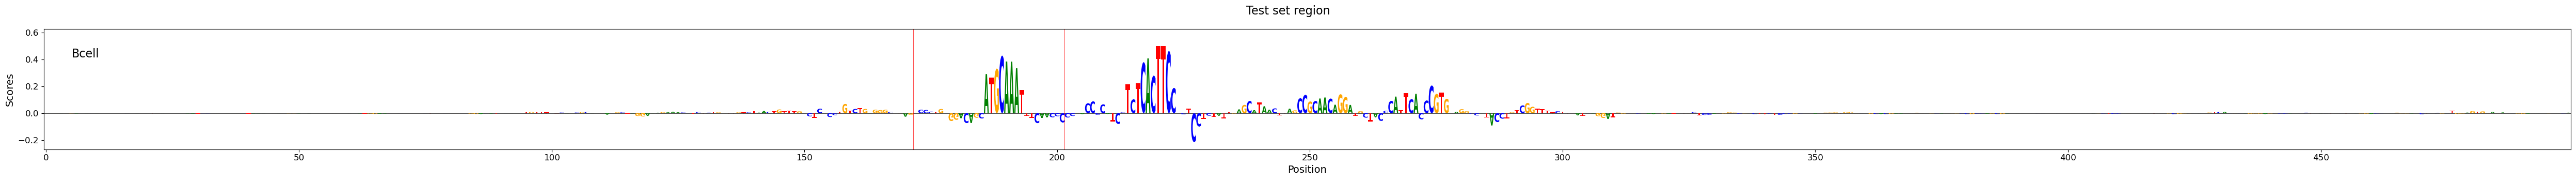

In [23]:
# Highlight identified seqlets
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Test set region",
    height=3.5,
    highlight_positions=seqlet_coords
)  # zoom in on the center 500bp


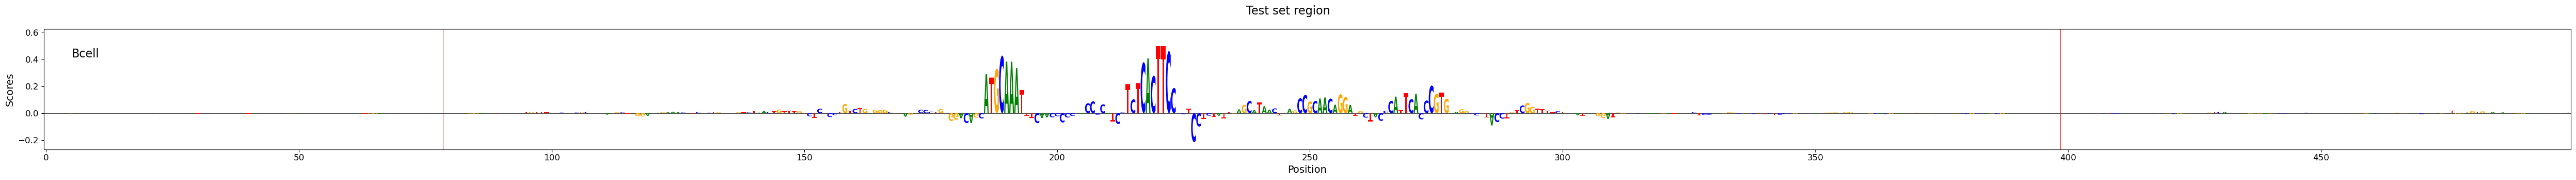

In [25]:
# Highlight ChIP peaks
crested.pl.patterns.contribution_scores(
    scores,                          
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Test set region",
    height=3.5,
    highlight_positions=chip_coords
)  # zoom in on the center 500bp

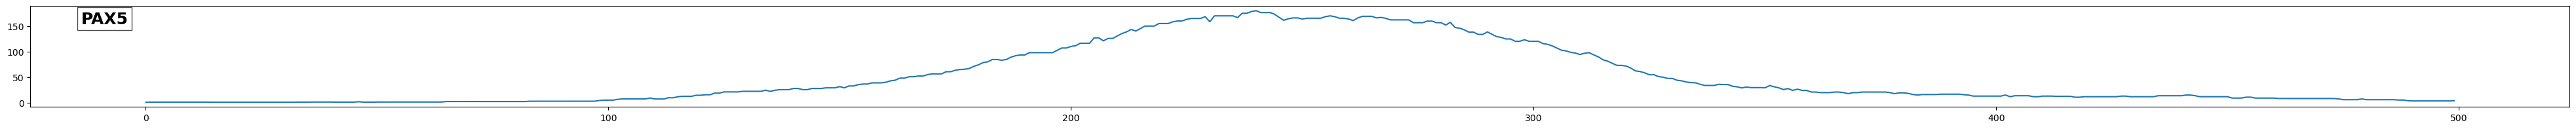

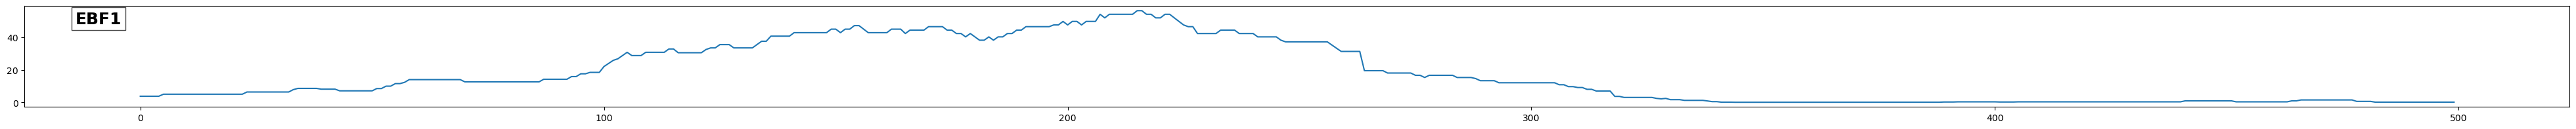

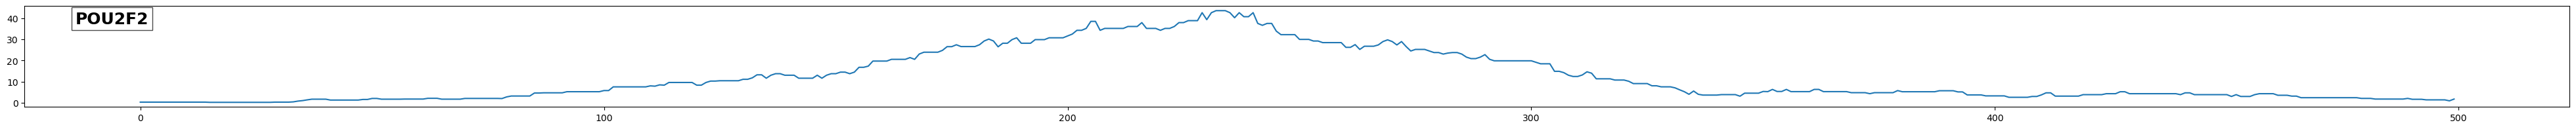

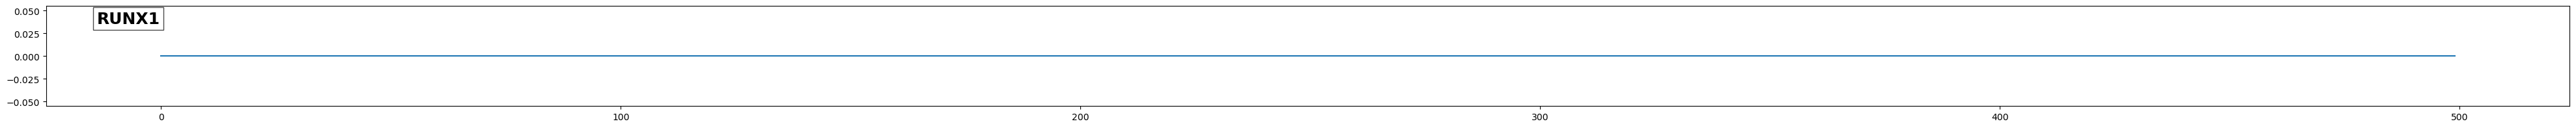

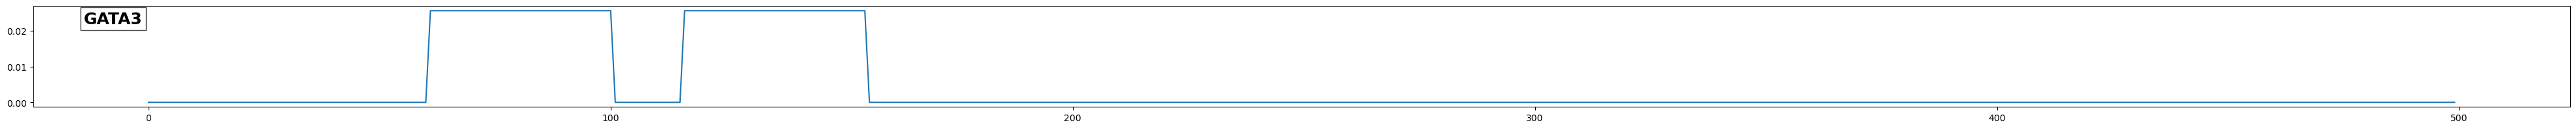

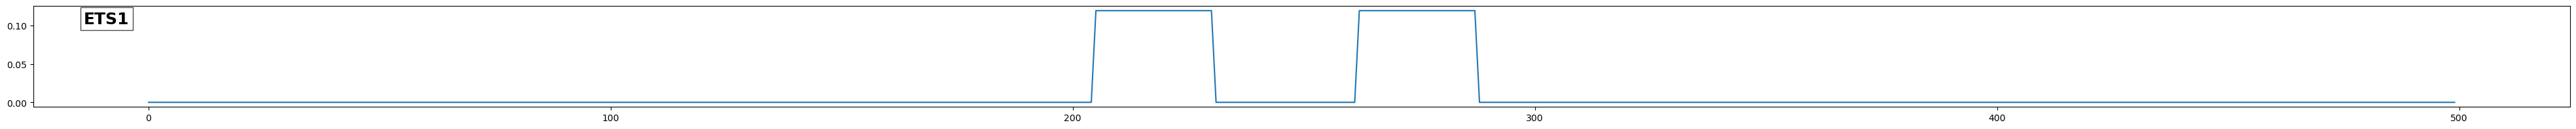

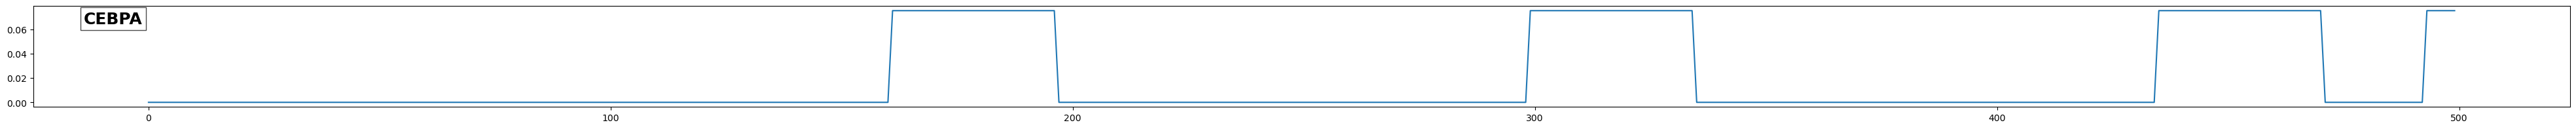

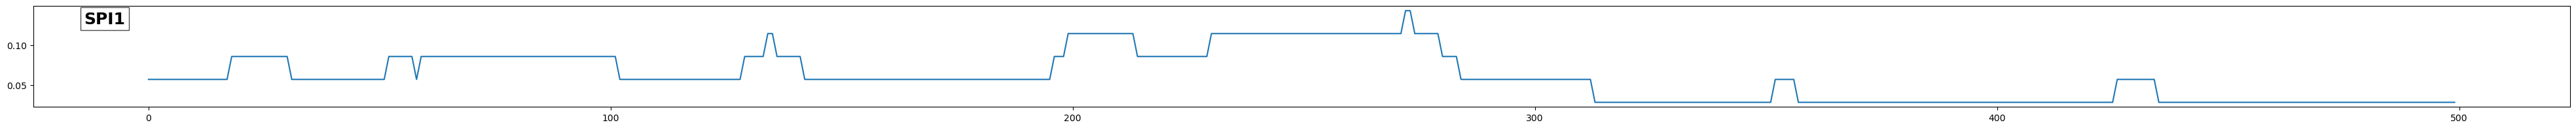

In [26]:
# Plot ChIP BigWigs
for chip_bw in chip_bw_files:
    filename = chip_bw.split('/')[-1].split('.')[0].upper()  # Extract and format filename

    # Read BigWig region
    vals, _ = crested.utils.read_bigwig_region(chip_bw, (chrom, start + 807, end - 807))

    # Plot
    plt.figure(figsize=(50, 2))
    plt.plot(np.arange(0, 500), vals)

    # Add filename as text in the top-left corner
    plt.text(0.02, 0.95, filename, transform=plt.gca().transAxes, fontsize=18, fontweight='bold', 
             verticalalignment='top',horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

    plt.show()

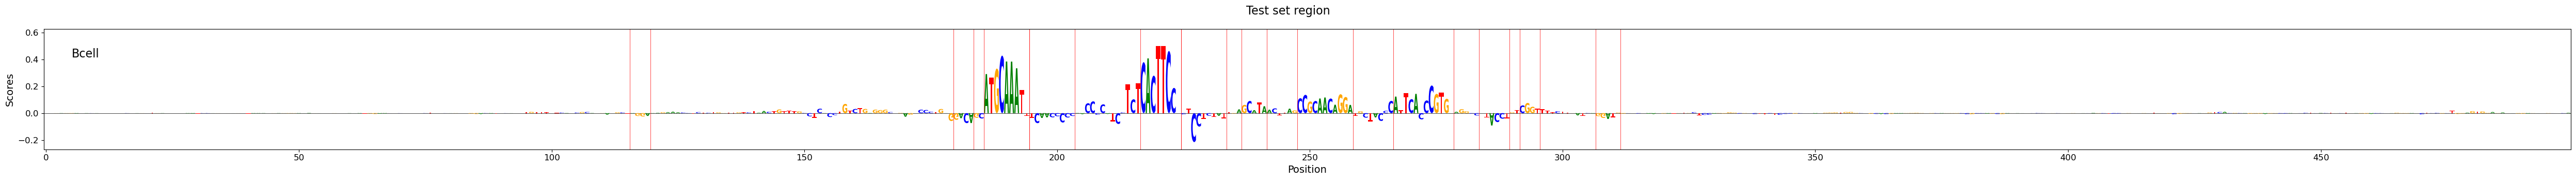

,example_idx,start,end,attribution,p-value
0,0,1032,1041,-0.442724,0.001959
1,0,1024,1032,2.712967,0.002801
2,0,987,991,-0.235548,0.005859
3,0,993,1002,2.570419,0.006512
4,0,1091,1097,-0.275842,0.008789
5,0,1002,1011,-0.357644,0.012695
6,0,1114,1119,-0.127250,0.026367
7,0,1055,1066,1.142279,0.027907
8,0,1074,1086,1.195366,0.032377
9,0,923,927,-0.069318,0.038086


In [30]:
# Plot all possible seqlets identified by tangermeme

from tangermeme.seqlet import recursive_seqlets
from crested.utils import one_hot_encode_sequence

oh_seq = one_hot_encode_sequence(sequence)[0].T
X_attr = scores[0,0].T
X_attr=X_attr*oh_seq
X_attr = np.expand_dims(np.sum(X_attr, axis=0),axis=0)

seqlets = recursive_seqlets(X_attr, threshold=0.05)

highlight_positions=[]
for i in range(len(seqlets)):
    start_ = seqlets.iloc[i]['start']
    end_ = seqlets.iloc[i]['end']
    highlight_positions.append((start_,end_))

crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Test set region",
    height=3.5,
    highlight_positions=highlight_positions
) 
seqlets

I0000 00:00:1741796452.406764 3519167 service.cc:145] XLA service 0x7fcfb400c020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741796452.406787 3519167 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-03-12 17:20:52.458906: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1741796453.274830 3519167 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


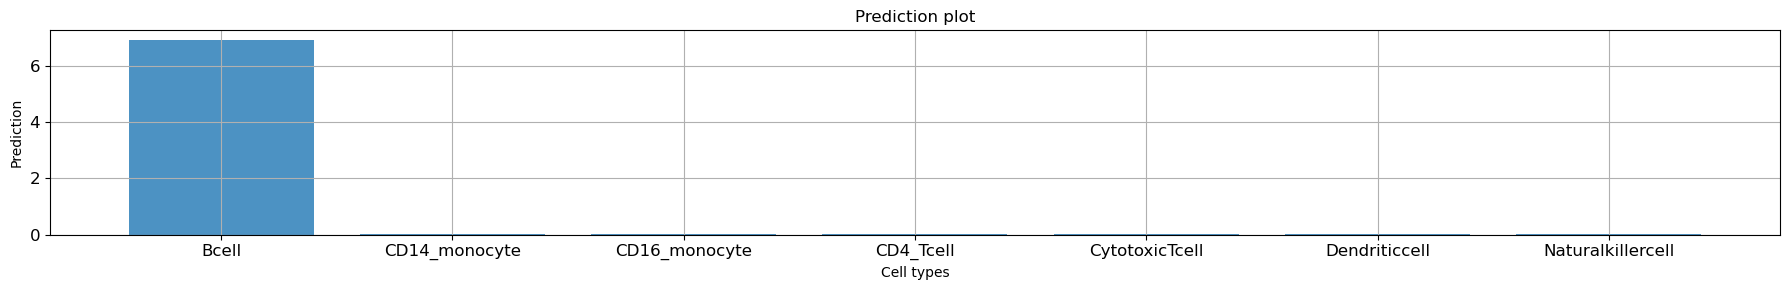

In [32]:
# Plot region predictions
sequence = genome.fetch(chrom, start, end).upper()

prediction = crested.tl.predict(sequence, model)


crested.pl.bar.prediction(prediction, classes=list(adata.obs_names))


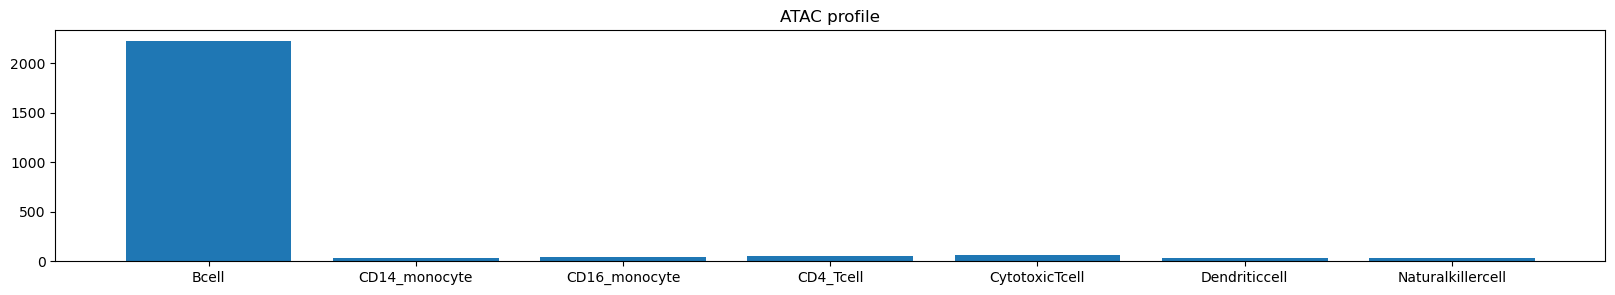

In [33]:
# Plot scATAC profile

bigwigs_folder = "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/sam/bw/"

vals = np.zeros(len(list(adata.obs_names)))
for i, ct in enumerate(list(adata.obs_names)):
    values = crested.utils.read_bigwig_region(bigwigs_folder+ct+'.bw', (chrom,start+557,end-557))
    bw_values=values[0]
    midpoints=values[1]
    vals[i] = np.sum(bw_values)*adata.obsm['weights'][i]

plt.figure(figsize=(20,3))
plt.bar(list(adata.obs_names), vals)
plt.title('ATAC profile')
plt.show()

## Recall of UniBind hits with seqlet calling

In [35]:
def get_row_with_overlap(df, input_start, input_end, overlap=0.5):
    """
    Retrieves the row with at least 30% overlap with the given input range.

    Parameters:
    df (pd.DataFrame): Input DataFrame with 'start' and 'end' columns.
    input_start (int): Start of the input range.
    input_end (int): End of the input range.
    overlap (float): Minimum overlap fraction required.

    Returns:
    pd.DataFrame: Row(s) with at least the specified overlap, sorted by overlap.
    """
    def overlap_fraction(row):
        # Calculate overlap
        overlap_start = max(row['start'], input_start)
        overlap_end = min(row['end'], input_end)
        overlap_length = max(0, overlap_end - overlap_start + 1)  # Ensure non-negative
        row_length = row['end'] - row['start'] + 1
        return overlap_length / row_length

    # Calculate overlap for each row and add as a new column
    df['overlap'] = df.apply(overlap_fraction, axis=1)

    # Filter rows with at least the specified overlap
    overlap_rows = df[df['overlap'] >= overlap]

    # Sort the filtered rows by the overlap column
    overlap_rows = overlap_rows.sort_values(by='overlap', ascending=False)

    return overlap_rows

In [37]:
from tqdm import tqdm

for tf in tf_dict:
    print(tf)
    filename=contribution_dir+'/'+tf_dict[tf]['cell_type']+'_contrib.npz'
    scores = np.load(filename)['arr_0']
    scores = np.transpose(scores,(0,2,1))
    oh_seqs=np.load(contribution_dir+'/'+tf_dict[tf]['cell_type']+'_oh.npz')['arr_0']
    oh_seqs = np.transpose(oh_seqs,(0,2,1))
    
    seqlet_starts=[]
    seqlet_ends = []
    p_values=[]
    attributions=[]
    attributions_exact=[]
    attributions_exact_padded=[]

    if tf_dict[tf]['unibind_hits_df'] is None:
        tf_dict[tf]['unibind_recall_df'] = None
        continue
    
    
    for i in tqdm(range(top_n)):
        oh_seq = oh_seqs[i].T
        X_attr = scores[i].T
        X_attr=X_attr*oh_seq
        X_attr = np.expand_dims(np.sum(X_attr, axis=0),axis=0)
        
        seqlets = recursive_seqlets(X_attr, threshold=0.05)
        region_id=tf_dict[tf]['region_df'].iloc[i]['region']
    
        if region_id in tf_dict[tf]['unibind_hits_df']['region'].values:
            rows = tf_dict[tf]['unibind_hits_df'].loc[tf_dict[tf]['unibind_hits_df']['region']==region_id]
            if len(rows)==1:
                row=rows
                chrom= row['region_chr']
                start=int(row['region_start'].iloc[0])
                end=int(row['region_end'].iloc[0])
                
                tf_start=int(row['chip_start'].iloc[0]-start)
                tf_end = int(row['chip_end'].iloc[0]-start)
            
                overlap_rows = get_row_with_overlap(seqlets, tf_start, tf_end)
                if len(overlap_rows)>0:
                    r = overlap_rows.iloc[0]
    
                    seq_start=start+int(r['start'])
                    seq_end = start+int(r['end'])
                                        
                    seqlet_starts.append(seq_start)
                    seqlet_ends.append(seq_end)
                    p_values.append(r['p-value'])
                    attributions.append(r['attribution'])
    
                    attribution = (np.mean(X_attr[0,int(r['start']):int(r['end'])]))
                    padding=(30-(int(r['end'])-int(r['start'])))//2
                    attribution_padded = (np.mean(X_attr[0,int(r['start'])-padding:int(r['end'])+padding]))
                    attributions_exact.append(attribution)
                    attributions_exact_padded.append(attribution_padded)            
            
                else:
                    seqlet_starts.append(np.nan)
                    seqlet_ends.append(np.nan)
                    p_values.append(np.nan)
                    attributions.append(np.nan)
                    attributions_exact.append(np.nan)
                    attributions_exact_padded.append(np.nan)
    
            else:
                for i in range(len(rows)):
                    chrom= rows['region_chr']
                    start=int(rows['region_start'].iloc[i])
                    end=int(rows['region_end'].iloc[i])
                    
                    tf_start=int(rows['chip_start'].iloc[i]-start)
                    tf_end = int(rows['chip_end'].iloc[i]-start)
    
                    overlap_rows = get_row_with_overlap(seqlets, tf_start, tf_end)
                    if len(overlap_rows)>0:
                        r = overlap_rows.iloc[0]
                        seq_start=start+int(r['start'])
                        seq_end = start+int(r['end'])
                                            
                        seqlet_starts.append(seq_start)
                        seqlet_ends.append(seq_end)
                        p_values.append(r['p-value'])
                        attributions.append(r['attribution'])
        
                        attribution = (np.mean(X_attr[0,int(r['start']):int(r['end'])]))
                        padding=(30-(int(r['end'])-int(r['start'])))//2
                        attribution_padded = (np.mean(X_attr[0,int(r['start'])-padding:int(r['end'])+padding]))
                        attributions_exact.append(attribution)
                        attributions_exact_padded.append(attribution_padded)       
                
                    else:
                        seqlet_starts.append(np.nan)
                        seqlet_ends.append(np.nan)
                        p_values.append(np.nan)
                        attributions.append(np.nan)
                        attributions_exact.append(np.nan)
                        attributions_exact_padded.append(np.nan)
    df_final = tf_dict[tf]['unibind_hits_df'].head(top_n).copy()
    df_final.loc[:,'seqlet_start'] = seqlet_starts
    df_final.loc[:,'seqlet_end'] = seqlet_ends
    df_final.loc[:,'seqlet_p_val']= p_values
    df_final.loc[:,'seqlet_attribution'] = attributions
    df_final.loc[:,'chip_attribution'] = attributions_exact
    df_final.loc[:,'chip_attribution_padded'] = attributions_exact_padded
    
    tf_dict[tf]['unibind_recall_df']=df_final

tf_dict['PAX5']['unibind_recall_df']
   

PAX5


100%|██████████| 1000/1000 [00:02<00:00, 384.49it/s]


EBF1


100%|██████████| 1000/1000 [00:02<00:00, 403.78it/s]


POU2F2
RUNX1


100%|██████████| 1000/1000 [00:02<00:00, 382.56it/s]


GATA3


100%|██████████| 1000/1000 [00:02<00:00, 371.57it/s]


ETS1


100%|██████████| 1000/1000 [00:02<00:00, 423.52it/s]


CEBPA


100%|██████████| 1000/1000 [00:02<00:00, 344.07it/s]


SPI1


100%|██████████| 1000/1000 [00:02<00:00, 419.67it/s]


,region,region_chr,region_start,region_end,chip_chr,chip_start,chip_end,chip_name,chip_score,chip_strand,status,seqlet_start,seqlet_end,seqlet_p_val,seqlet_attribution,chip_attribution,chip_attribution_padded
0,chr3:16432755-16434869,chr3,16432755,16434869,chr3,16433797,16433809,PAX5_GAGCATAACTTA,91.8,+,Possible Hit,16433799.0,16433804.0,0.044049,0.299434,0.059887,0.020555
1,chr15:69978952-69981066,chr15,69978952,69981066,chr15,69980021,69980033,PAX5_AAGTATGACTGT,89.2,-,Possible Hit,69980024.0,69980028.0,0.034836,0.341985,0.085496,0.049637
2,chr6:106701526-106703640,chr6,106701526,106703640,chr6,106702584,106702596,PAX5_AAGCATGACAGA,94.6,+,Possible Hit,106702576.0,106702595.0,0.033831,1.312064,0.069056,0.055004
3,chr10:1488137-1490251,chr10,1488137,1490251,chr10,1489361,1489373,PAX5_AGGCGTGACCGT,93.5,+,Possible Hit,1489363.0,1489371.0,0.012973,0.924269,0.115534,0.029751
4,chr18:79257665-79259779,chr18,79257665,79259779,chr18,79258698,79258710,PAX5_AAGCATGACTGA,95.1,-,Possible Hit,79258692.0,79258710.0,0.034358,1.867699,0.103761,0.071793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,chr16:81820608-81822722,chr16,81820608,81822722,chr16,81821709,81821721,PAX5_GAGCGCAGAGCC,87.0,+,Possible Hit,81821704.0,81821715.0,0.009166,0.900392,0.081854,0.039236
383,chr7:66914109-66916223,chr7,66914109,66916223,chr7,66915106,66915118,PAX5_AACCATGACCGC,91.9,-,Possible Hit,66915099.0,66915123.0,0.027599,0.585275,0.024386,0.020641
384,chr19:50416501-50418615,chr19,50416501,50418615,chr19,50417833,50417845,PAX5_ACCCGCAGCCGG,88.9,+,Possible Hit,NaN,NaN,NaN,NaN,NaN,NaN
385,chr10:59875308-59877422,chr10,59875308,59877422,chr10,59876376,59876388,PAX5_ATGCATTACATG,87.5,+,Possible Hit,59876371.0,59876384.0,0.003981,0.094775,0.007290,0.004228


In [38]:
recalls ={}

for tf in tf_dict:
    if tf_dict[tf]['unibind_recall_df'] is not None:
            print(tf)
            # Determine true positives (non-NaN in seqlet_start)
            true_positives = tf_dict[tf]['unibind_recall_df']['seqlet_start'].notna().sum()
            
            # Determine false negatives (NaN in seqlet_start)
            false_negatives = tf_dict[tf]['unibind_recall_df']['seqlet_start'].isna().sum()

            # Calculate recall
            recall = true_positives / (true_positives + false_negatives)

            recalls[tf] = {}
            recalls[tf]['recall']=recall
            recalls[tf]['total']=true_positives+false_negatives

            # Output the results
            print(f"True Positives (TP): {true_positives}")
            print(f"False Negatives (FN): {false_negatives}")
            print(f"Recall: {recall:.2f}")
    else:
        print('No unibind bed file provided for '+tf)

PAX5
True Positives (TP): 292
False Negatives (FN): 95
Recall: 0.75
EBF1
True Positives (TP): 208
False Negatives (FN): 48
Recall: 0.81
No unibind bed file provided for POU2F2
RUNX1
True Positives (TP): 312
False Negatives (FN): 31
Recall: 0.91
GATA3
True Positives (TP): 212
False Negatives (FN): 226
Recall: 0.48
ETS1
True Positives (TP): 64
False Negatives (FN): 4
Recall: 0.94
CEBPA
True Positives (TP): 589
False Negatives (FN): 34
Recall: 0.95
SPI1
True Positives (TP): 41
False Negatives (FN): 9
Recall: 0.82


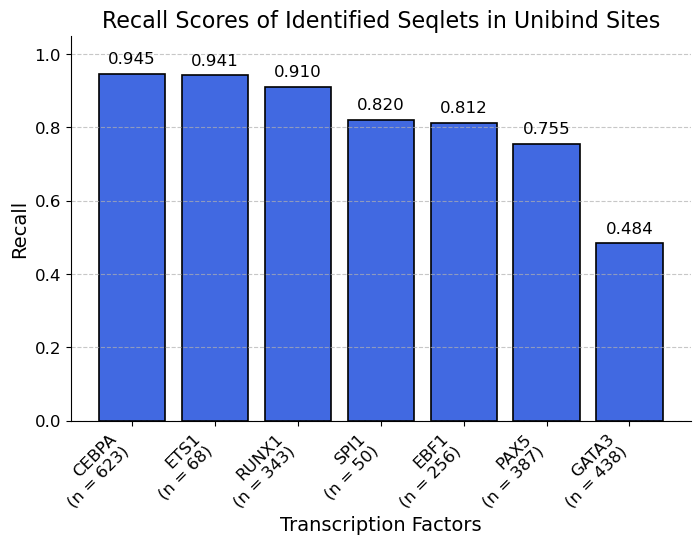

In [39]:
# Sorting by recall values
sorted_factors = sorted(recalls, key=lambda x: recalls[x]['recall'], reverse=True)
sorted_recalls = [recalls[factor]['recall'] for factor in sorted_factors]
sorted_totals = [recalls[factor]['total'] for factor in sorted_factors]

# Generate new x-axis labels with (n = total)
x_labels = [f"{factor}\n(n = {total})" for factor, total in zip(sorted_factors, sorted_totals)]

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x_labels, sorted_recalls, color='royalblue', edgecolor='black', linewidth=1.2)

# Aesthetics
ax.set_ylabel('Recall', fontsize=14)
ax.set_xlabel('Transcription Factors', fontsize=14)
ax.set_title('Recall Scores of Identified Seqlets in Unibind Sites', fontsize=16)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', 
            ha='center', va='bottom', fontsize=12, color='black')

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.xticks(rotation=45, fontsize=12, ha='right', va='top')
plt.yticks(fontsize=12)
#plt.savefig('paperfigs/unibind_recall.pdf', bbox_inches='tight')
plt.show()

## Check ChIP and ATAC peak heights in identified seqlets

In [40]:
for tf in tf_dict:
    tf_dict[tf]['atac_bw_file']="/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/bw/"+tf_dict[tf]['cell_type']+".bw"

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from crested.utils import read_bigwig_region  # Ensure you have the required module

def plot_average_peak_height(bigwig_file, region_df, padding=0, seqlet_len=30, cols=None,max_carrot=None, title='', save_path=None):
    """
    Plot a histogram of average peak heights and a heatmap carrot plot for all peak values.
    
    Parameters:
    - bigwig_file (str): Path to the BigWig file.
    - region_df (pd.DataFrame): DataFrame with columns ['region', 'chr', 'start', 'end'].
    - padding (int): Number of bases to add as flanking around the regions.
    - seqlet_len (int): Expected sequence length for normalization.
    - cols (list): Column names for chrom, start, end. Defaults to ['chr', 'start', 'end'].
    """
    # Setup columns
    if cols:
        chrom_col = cols[0]
        start_col = cols[1]
        end_col = cols[2]
    else:
        chrom_col = 'chr'
        start_col = 'start'
        end_col = 'end'

    # Initialize peak values
    window_length = seqlet_len + 2 * padding
    peaks = np.zeros((len(region_df), window_length))
    avg_peak_heights = []

    for i, row in region_df.iterrows():
        chrom = row[chrom_col]
        start = int(row[start_col])
        end = int(row[end_col])
        seq_len = end - start

        # Normalize to seqlet_len
        if seq_len > seqlet_len:
            diff = (seq_len - seqlet_len) // 2
            start = start + diff
            end = end - diff
        elif seq_len < seqlet_len:
            diff = (seqlet_len - seq_len) // 2
            start = start - diff
            end = end + diff

        seq_len = end-start

        if seq_len<seqlet_len:
            end=end+1

        # Read the BigWig region with flanking
        values, _ = read_bigwig_region(bigwig_file, (chrom, start - padding, end + padding))
        
        # Handle peak values
        #if len(values) >= window_length:
        peaks[i] = values[:window_length]
        avg_peak_heights.append(np.mean(values))
        #else:
        #    peaks[i] = np.pad(values, (0, window_length - len(values)), 'constant', constant_values=0)
        #    avg_peak_heights.append(np.mean(values) if len(values) > 0 else 0)
    avg_peaks = np.mean(peaks,axis=0) 

    num_figs= 3 if max_carrot else 2 
    # Plot histogram of average peak heights
    fig, axes = plt.subplots(1, num_figs , figsize=(num_figs*4, 6))
    x_start = -window_length/2
    x_end = window_length/2
    # Histogram
    # Plot
    axes[0].plot(np.arange(x_start,x_end),avg_peaks)
    axes[0].set_title("Average Peak Height in Regions "+title)
    axes[0].set_xlabel("Position")
    axes[0].set_ylabel("Average Peak Height")
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    

    peak_max_values = np.max(peaks, axis=1)  # Find max value for each row
    sorted_indices = np.argsort(peak_max_values)[::-1]  # Sort indices in descending order
    sorted_peaks = peaks[sorted_indices]  # Reorder rows based on sorted indices

    # Heatmap carrot plot
    im = axes[1].imshow(
        sorted_peaks, 
        aspect='auto', 
        cmap='coolwarm', 
        extent=[-window_length // 2, window_length // 2, 0, len(region_df)]
    )
    axes[1].set_title("Carrot Plot of Peak Values "+(title))
    axes[1].set_xlabel("Position (relative to center)")
    axes[1].set_ylabel("Region Index")
    fig.colorbar(im, ax=axes[1], orientation='vertical', label='Peak Value')

    if max_carrot:
        peaks_carrot = np.clip(peaks, 0, max_carrot)
        peak_max_values = np.max(peaks_carrot, axis=1)  # Find max value for each row
        sorted_indices = np.argsort(peak_max_values)[::-1]  # Sort indices in descending order
        sorted_peaks = peaks_carrot[sorted_indices]  # Reorder rows based on sorted indices
    
        # Heatmap carrot plot
        im = axes[2].imshow(
            sorted_peaks, 
            aspect='auto', 
            cmap='coolwarm', 
            extent=[-window_length // 2, window_length // 2, 0, len(region_df)]
        )
        axes[2].set_title("Carrot Plot of Peak Values - Clipped  "+(title))
        axes[2].set_xlabel("Position (relative to center)")
        axes[2].set_ylabel("Region Index")
        fig.colorbar(im, ax=axes[2], orientation='vertical', label='Peak Value')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    return peaks


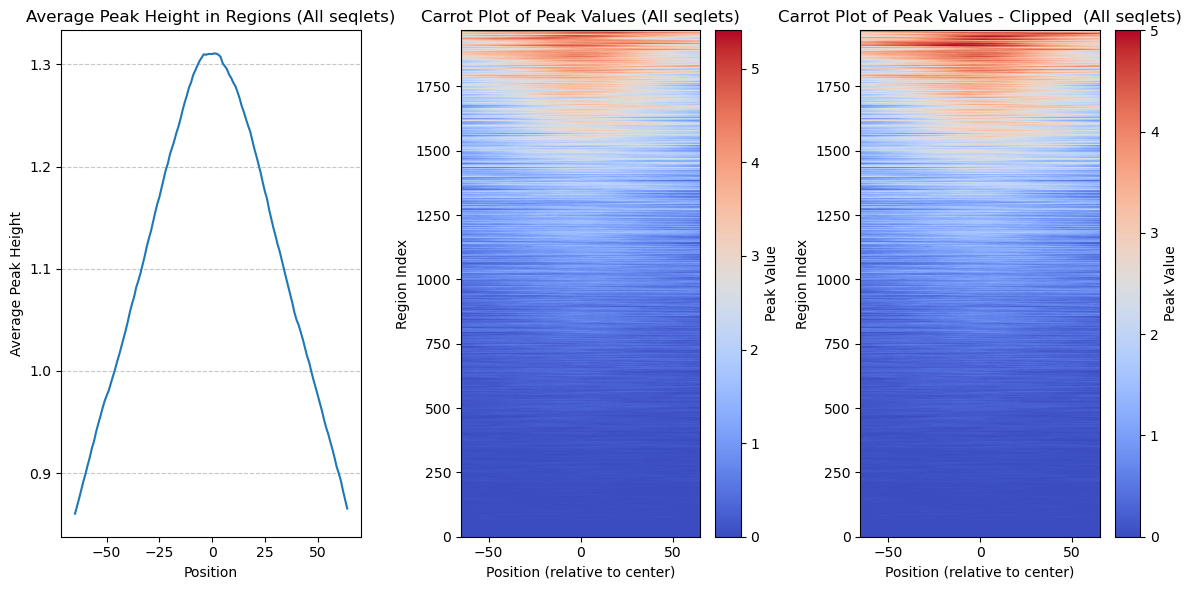

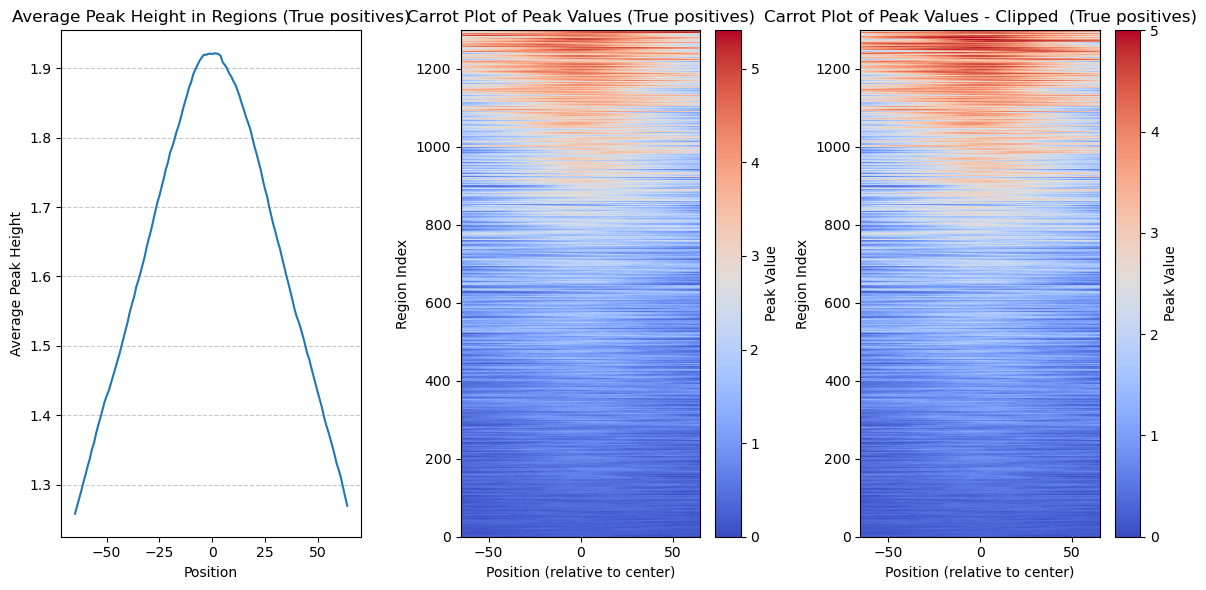

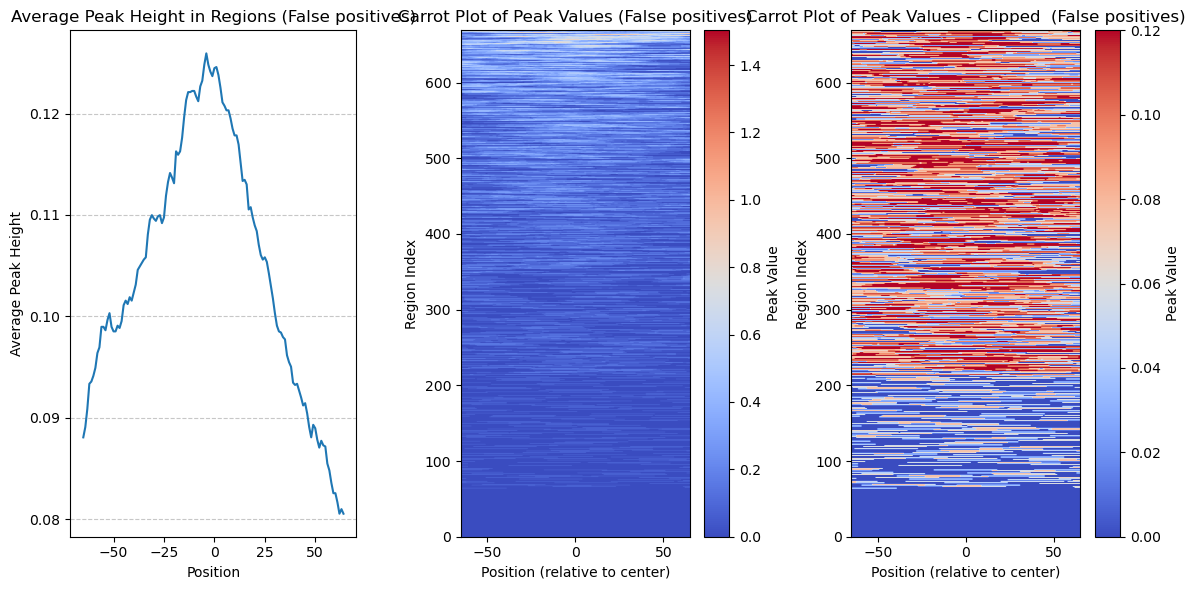

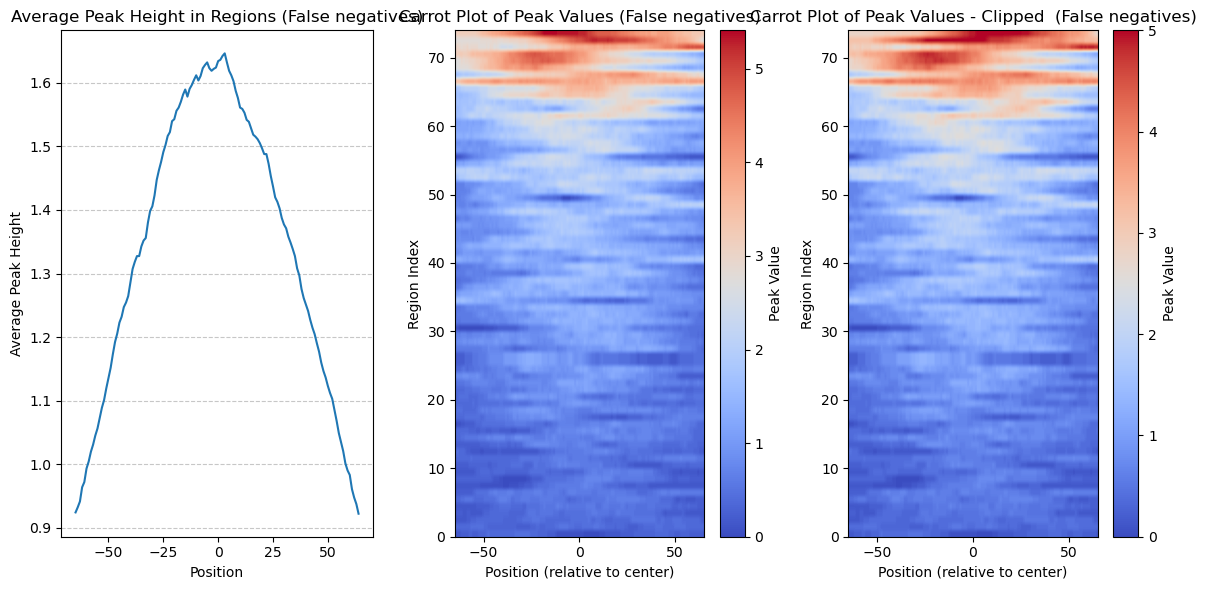

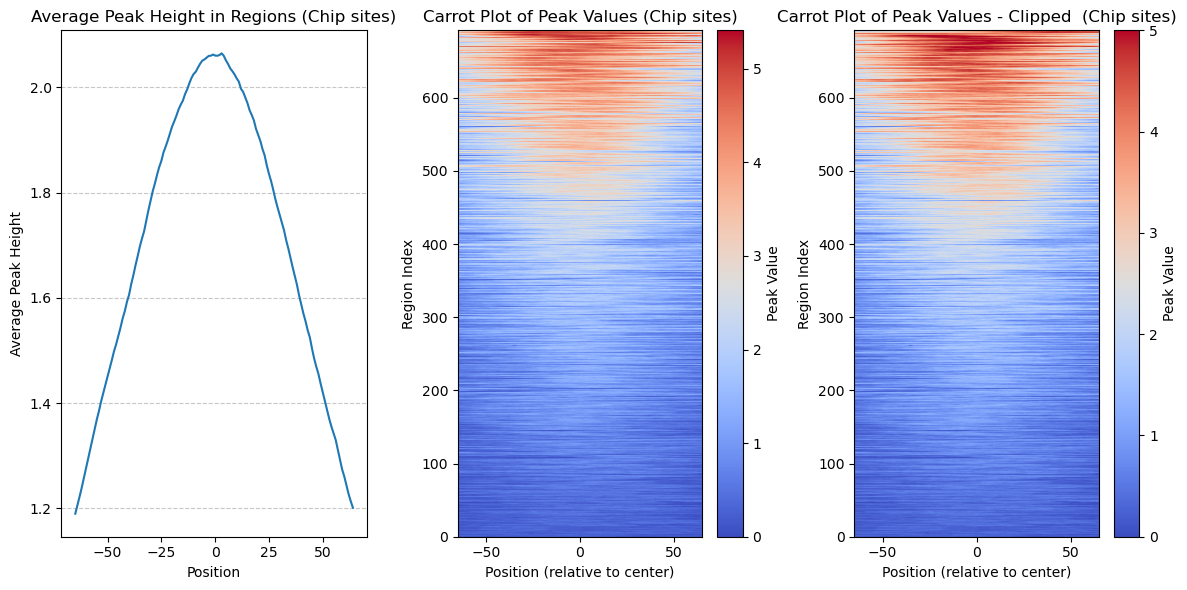

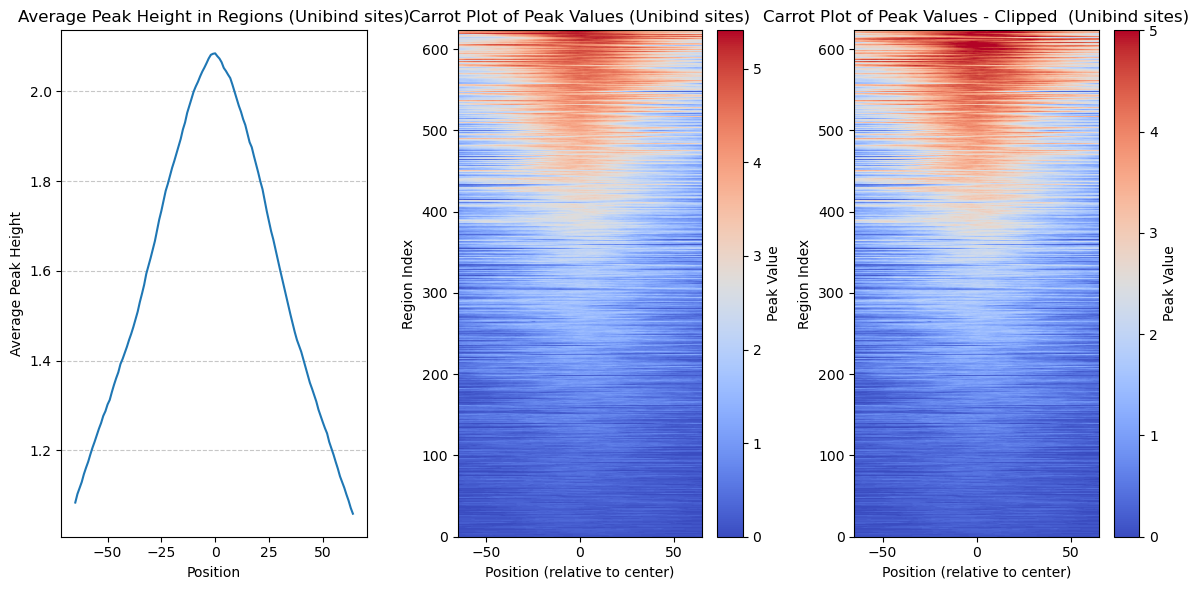

In [44]:
tf = 'CEBPA'

bw_file =tf_dict[tf]['chip_bw']
seqlet_df = tf_dict[tf]['seqlet_df']
results_df = tf_dict[tf]['results_df']

possible_hits_df = tf_dict[tf]['chip_hits_df']
possible_hits_df_unibind = tf_dict[tf]['unibind_hits_df']

peaks=plot_average_peak_height(bw_file, seqlet_df, padding=50, max_carrot=5, title='(All seqlets)')#, save_path='paperfigs/'+tf+'_all_seqlets.pdf')
results_df_tp = results_df.loc[results_df['status']=='True Positive'].reset_index()
_=plot_average_peak_height(bw_file, results_df_tp, padding=50, cols=['seqlet_chr','seqlet_start','seqlet_end'],max_carrot=5,title='(True positives)')
results_df_fp = results_df.loc[results_df['status']=='False Positive'].reset_index()
_=plot_average_peak_height(bw_file, results_df_fp, padding=50, cols=['seqlet_chr','seqlet_start','seqlet_end'],max_carrot=0.12, title='(False positives)')#, save_path='paperfigs/'+tf+'_FP.pdf')
results_df_fn = results_df.loc[results_df['status']=='False Negative'].reset_index()
_=plot_average_peak_height(bw_file, results_df_fn, padding=50, cols=['chip_chr','chip_start','chip_end'],max_carrot=5,title='(False negatives)')
_=plot_average_peak_height(bw_file, possible_hits_df, padding=50, cols=['chip_chr','chip_start','chip_end'],max_carrot=5,title='(Chip sites)')
_=plot_average_peak_height(bw_file, possible_hits_df_unibind, padding=50, cols=['chip_chr','chip_start','chip_end'],max_carrot=5,title='(Unibind sites)')



In [45]:
results_df

,region,seqlet_chr,seqlet_start,seqlet_end,seqlet_average_contrib,chip_chr,chip_start,chip_end,chip_name,chip_score,chip_strand,status
0,chr7:75950646-75952760,chr7,75951635.0,75951665.0,0.062295,chr7,75951524.0,75951835.0,SRX097095.05_peak_49248,1740.0,.,True Positive
1,chr2:173158914-173161028,chr2,173159999.0,173160029.0,0.026294,chr2,173159862.0,173160094.0,SRX097095.05_peak_29828,1918.0,.,True Positive
2,chr2:32559786-32561900,chr2,32560787.0,32560817.0,0.022643,chr2,32560729.0,32560915.0,SRX097095.05_peak_26783,851.0,.,True Positive
3,chr8:31832641-31834755,chr8,31833663.0,31833693.0,0.025196,chr8,31833500.0,31833892.0,SRX097095.05_peak_51379,1848.0,.,True Positive
4,chr22:31203674-31205788,chr22,31204569.0,31204599.0,0.021831,chr22,31204489.0,31204658.0,SRX097095.05_peak_33847,726.0,.,True Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
2037,chr12:89730777-89732891,NaN,NaN,NaN,NaN,chr12,89731702.0,89731887.0,SRX097095.05_peak_12712,696.0,.,False Negative
2038,chr3:129485448-129487562,NaN,NaN,NaN,NaN,chr3,129485775.0,129486068.0,SRX097095.05_peak_36729,706.0,.,False Negative
2039,chr3:4813053-4815167,NaN,NaN,NaN,NaN,chr3,4814031.0,4814151.0,SRX097095.05_peak_34337,236.0,.,False Negative
2040,chr11:111845174-111847288,NaN,NaN,NaN,NaN,chr11,111845639.0,111845849.0,SRX097095.05_peak_10412,1454.0,.,False Negative


# Recall of seqlets on UniBind hits inside all consensus peaks

In [47]:
peak_bed="/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/sam/consensus_regions.bed"
peak_df = pd.read_csv(peak_bed, sep="\t", header=None, names=column_names)
peak_df

,chrom,start,end,name,score,strand
0,chr1,817094,817594,CD16_monocyte_peak_4,197,.
1,chr1,818575,819075,CytotoxicTcell_peak_9,0,.
2,chr1,819821,820321,CytotoxicTcell_peak_10,2,.
3,chr1,820583,821083,CD14_monocyte_peak_14a,1,.
4,chr1,821323,821823,CD14_monocyte_peak_14b,4,.
...,...,...,...,...,...,...
327959,chrY,21260264,21260764,CD4_Tcell_peak_104744,11,.
327960,chrY,21300185,21300685,Dendriticcell_peak_89630,11,.
327961,chrY,21302627,21303127,Dendriticcell_peak_89631,11,.
327962,chrY,21422119,21422619,Dendriticcell_peak_89632,17,.


## Calculate overlapping ChIP peaks and consensus regions

In [ ]:
from tqdm import tqdm
ct_list= ['Bcell',
          'Bcell',
          'CD4_Tcell',
          'CD4_Tcell',
          'CD4_Tcell',
          'CD14_monocyte',
          'CD14_monocyte'
         ]

chip_bed_files = [
    '/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pax5/pax5.bed',
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/ebf1_unibind.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/runx1.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/gata3.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ets1/ets1_unibind.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/cebpa/cebpa.bed",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/spi1_2/spi1.bed",
]

unibind_dfs = []

for chip_bed_file in tqdm(chip_bed_files):
    print(chip_bed_file)
    column_names = ["chrom", "start", "end", "name", "score", "strand"]

    # Read the unibind bed files
    chip_df = pd.read_csv(chip_bed_file, sep="\t", header=None, names=column_names)
    
    # Merge the two DataFrames on overlapping intervals
    merged_df = pd.merge(
        chip_df,
        peak_df,
        on="chrom",
        suffixes=("_chip", "_peak")
    )
    
    # Filter for overlaps
    subset_chip_df = merged_df[
        (merged_df["start_chip"] >= merged_df["start_peak"]) &
        (merged_df["end_chip"] <= merged_df["end_peak"])
    ]
    
    sorted_chip_df = subset_chip_df.sort_values(by="score_chip", ascending=False)
    unibind_dfs.append(sorted_chip_df)


  0%|          | 0/7 [00:00<?, ?it/s]

/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pax5/pax5.bed


 14%|█▍        | 1/7 [00:57<05:46, 57.75s/it]

/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/ebf1_unibind.bed


 29%|██▊       | 2/7 [01:28<03:28, 41.62s/it]

/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/runx1.bed


 43%|████▎     | 3/7 [02:08<02:44, 41.02s/it]

/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/gata3.bed


## Calculate contribution scores for all overlapping regions 
WARNING: TAKES A LONG TIME

just load the results

In [ ]:
#out_dirs = [
#    '/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pax5/',
#    #"/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/",
#    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/",
#    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/",
#    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ets1/",
#    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/cebpa/",
#    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/spi1_2/",
#]
#for a, sorted_chip_df in enumerate(unibind_dfs):
#    top_n=len(sorted_chip_df)
#   
#    sequences=[]
#    for i in range(top_n):
#        row= sorted_chip_df.iloc[i]
#        
#        chrom= row['chrom']
#        start=int(row['start_peak']-807)
#        end=int(row['end_peak']+807)
#        sequence = genome.fetch(chrom, start, end).upper()
#        sequences.append(sequence)
#    scores, one_hot_encoded_sequences = evaluators[2].calculate_contribution_scores_sequence(sequences, ct_list[a], method='expected_integrated_grad', disable_tqdm=False)
#    scores = np.squeeze(scores, axis=1)
#    scores = np.transpose(scores,(0,2,1))
#    print(scores.shape)
#    one_hot_encoded_sequences = np.transpose(one_hot_encoded_sequences,(0,2,1))
#    np.savez(out_dirs[a]+"/Sam_"+ct_list[a]+"_contrib.npz",scores)
#    np.savez(out_dirs[a]+"/Sam_"+ct_list[a]+"_oh.npz", one_hot_encoded_sequences)
    

In [ ]:
out_dirs = [
    '/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/pax5/',
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ebf1/",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/runx1/",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/gata3_2/",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/ets1/",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/cebpa/",
    "/home/VIB.LOCAL/niklas.kempynck/nkemp/pbmc/chip/spi1_2/",
]
ct_list= ['Bcell',
          'Bcell',
          'CD4_Tcell',
          'CD4_Tcell',
          'CD4_Tcell',
          'CD14_monocyte',
          'CD14_monocyte'
         ]

recalls={}
tfs=['PAX5','EBF1','RUNX1','GATA3','ETS1','CEBPA','SPI']
a=0
for ct, outdir, sorted_chip_df, tf in zip(ct_list, out_dirs, unibind_dfs, tfs):
    scores = np.load(outdir+"Sam_"+ct+"_contrib.npz")['arr_0']
    scores = np.transpose(scores, (0,2,1))
    one_hot_encoded_sequences = np.load(outdir+"Sam_"+ct+"_oh.npz")['arr_0']
    one_hot_encoded_sequences = np.transpose(one_hot_encoded_sequences, (0,2,1))

    print(scores.shape)
    print(sorted_chip_df.shape)
    from tqdm import tqdm
    
    seqlet_starts=[]
    seqlet_ends = []
    p_values=[]
    attributions=[]
    attributions_exact=[]
    overlaps=[]
    
    
    for i in tqdm(range(len(sorted_chip_df))):
        oh_seq = one_hot_encode_sequence(sequences[i])[0].T#one_hot_encoded_sequences[i].T
        X_attr = scores[i].T
        X_attr=X_attr*oh_seq
        X_attr = np.expand_dims(np.sum(X_attr, axis=0),axis=0)
        
        seqlets = recursive_seqlets(X_attr, threshold=0.05)
        
        row=sorted_chip_df.iloc[i]
        
        chrom= row['chrom']
        start=int(row['start_peak']-807)
        end=int(row['end_peak']+807)
        
        tf_start=int(row['start_chip']-start)
        tf_end = int(row['end_chip']-start)
    
        attribution = (np.mean(X_attr[0,tf_start:tf_end]))
    
        overlap_rows = get_row_with_overlap(seqlets, tf_start, tf_end)
        if len(overlap_rows)>0:
            r = overlap_rows.iloc[0]
            seqlet_starts.append(start+int(r['start']))
            seqlet_ends.append(start+int(r['end']))
            p_values.append(r['p-value'])
            attributions.append(r['attribution'])
            overlaps.append(r['overlap'])
            attributions_exact.append(attribution)
    
        else:
            seqlet_starts.append(np.nan)
            seqlet_ends.append(np.nan)
            p_values.append(np.nan)
            attributions.append(np.nan)
            overlaps.append(np.nan)
            attributions_exact.append(attribution)

    df_final = sorted_chip_df.head(top_n).copy()
    df_final.loc[:,'seqlet_start'] = seqlet_starts
    df_final.loc[:,'seqlet_end'] = seqlet_ends
    df_final.loc[:,'seqlet_p_val']= p_values
    df_final.loc[:,'seqlet_attribution'] = attributions
    df_final.loc[:,'chip_attribution'] = attributions_exact
    df_final.loc[:,'UniBind-Seqlet overlap fraction'] = overlaps


    true_positives = df_final['seqlet_start'].notna().sum()
    
    # Determine false negatives (NaN in seqlet_start)
    false_negatives = df_final['seqlet_start'].isna().sum()
    
    # Calculate recall
    recall = true_positives / (true_positives + false_negatives)
    
    # Output the results
    print(f"True Positives (TP): {true_positives}")
    print(f"False Negatives (FN): {false_negatives}")
    print(f"Recall: {recall:.2f}")
    recalls[tf]={}
    recalls[tf]['recall']=recall
    recalls[tf]['total']=true_positives+false_negatives
    unibind_dfs[a]=df_final
    a+=1

In [ ]:
# Sorting by recall values
sorted_factors = sorted(recalls, key=lambda x: recalls[x]['recall'], reverse=True)
sorted_recalls = [recalls[factor]['recall'] for factor in sorted_factors]
sorted_totals = [recalls[factor]['total'] for factor in sorted_factors]

# Generate new x-axis labels with (n = total)
x_labels = [f"{factor}\n(n = {total})" for factor, total in zip(sorted_factors, sorted_totals)]

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x_labels, sorted_recalls, color='royalblue', edgecolor='black', linewidth=1.2)

# Aesthetics
ax.set_ylabel('Recall', fontsize=14)
ax.set_xlabel('Transcription Factors', fontsize=14)
ax.set_title('Recall Scores of Identified Seqlets in Unibind Sites', fontsize=16)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', 
            ha='center', va='bottom', fontsize=12, color='black')

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.xticks(rotation=45, fontsize=12, ha='right', va='top')
plt.yticks(fontsize=12)
#plt.savefig('paperfigs/unibind_recall_ALL.pdf', bbox_inches='tight')
plt.show()